## WIF3009 – Python for Scientific Computing
### Group Project Assignment

### Topic 2: Predicting Housing Prices

**Group Number:** 9

**Group Members:**
- Lutfil Hadi bin Abdul Rahim (U2000499)
- Tengku Puteri Emilia binti Tengku Nazaruddin Shah (U2000865)
- Jee Jian Qi (U2102861)
- Amirul Aiman bin Mohsine (U2000595)

## 1. Introduction

## 2. Data
### 2.1 Dataset Description
- **Dataset:** Property Listings in Kuala Lumpur
- **Source:** Kaggle
- **URL:** [Kaggle Property Listings in Kuala Lumpur](https://www.kaggle.com/datasets/dragonduck/property-listings-in-kuala-lumpur/data)
- The dataset contains information about property listings in Kuala Lumpur, including features such as location, price, number of rooms, bathrooms, car parks, property type, size, and furnishing.

In [1]:
import re
import numpy as np
import pandas as pd
from html import unescape
from scipy.stats import skew

### 2.2 Data Importing

In [2]:
df = pd.read_csv('data/data_kaggle.csv')

df.head()

Location         Price Rooms  Bathrooms  Car Parks  \
0               KLCC, Kuala Lumpur  RM 1,250,000   2+1        3.0        2.0   
1  Damansara Heights, Kuala Lumpur  RM 6,800,000     6        7.0        NaN   
2            Dutamas, Kuala Lumpur  RM 1,030,000     3        4.0        2.0   
3             Cheras, Kuala Lumpur           NaN   NaN        NaN        NaN   
4        Bukit Jalil, Kuala Lumpur    RM 900,000   4+1        3.0        2.0   

          Property Type                      Size        Furnishing  
0    Serviced Residence  Built-up : 1,335 sq. ft.   Fully Furnished  
1              Bungalow  Land area : 6900 sq. ft.  Partly Furnished  
2  Condominium (Corner)  Built-up : 1,875 sq. ft.  Partly Furnished  
3                   NaN                       NaN               NaN  
4  Condominium (Corner)  Built-up : 1,513 sq. ft.  Partly Furnished

### 2.3 Data Cleaning

#### 2.3.1 Price Column
**Removing 'RM' and Converting Price to Numeric:**
The 'Price' column initially contains the string 'RM' and commas, which need to be removed to convert the values to numeric format.

In [3]:
# Remove 'RM" and convert to numeric
df['Price'] = df['Price'].str.replace('RM', '').str.replace(',', '').astype(float)
df['Price']

0        1250000.0
1        6800000.0
2        1030000.0
3              NaN
4         900000.0
           ...    
53878    5100000.0
53879    5000000.0
53880    5500000.0
53881     480000.0
53882     540000.0
Name: Price, Length: 53883, dtype: float64

#### 2.3.2 Location Column

To standardize and simplify the 'Location' column, we extracted only the district name and converted it to uppercase.

**Extracting District Name and Converting to Uppercase:**
The 'Location' column originally contains the district name followed by ", Kuala Lumpur". We removed ", Kuala Lumpur" and converted the remaining district name to uppercase.


In [4]:
# Only take the district name
df['Location'] = df['Location'].str.replace(', Kuala Lumpur', '').str.upper()

#### 2.3.3 Rooms Column

The 'Rooms' column contains information about the number of rooms in a property, sometimes in a format that includes additional rooms (e.g., "2+1"). To standardize this column, we developed a function to clean and convert these values into a single integer representing the total number of rooms.

**Cleaning the 'Rooms' Column:**
We created a function `clean_rooms` to handle the cleaning process. This function uses regular expressions to parse the number of main rooms and additional rooms, then sums them to get the total number of rooms.

In [5]:
# Clean Rooms column
def clean_rooms(rooms):
    if pd.isna(rooms):
        return None
    match = re.match(r"(\d+)(\+(\d+))?", rooms)
    if match:
        main_rooms = int(match.group(1))
        additional_rooms = int(match.group(3)) if match.group(3) else 0
        return main_rooms + additional_rooms
    return None

df['Rooms'] = df['Rooms'].apply(clean_rooms)
df['Rooms']

0        3.0
1        6.0
2        3.0
3        NaN
4        5.0
        ... 
53878    6.0
53879    5.0
53880    6.0
53881    3.0
53882    4.0
Name: Rooms, Length: 53883, dtype: float64

#### 2.3.4 Size Column

The 'Size' column contains the property size in various formats. To standardize this column and extract the numeric values, we developed a function to handle different formats and convert them into square feet.

Examples:
- Single numeric with sq. ft.: 3600 sq. ft.
- Simple dimensions: 20x75 sq. ft.
- Range values: 646sf~1001sf sq. ft.
- Dimensions with area : 20x75(1500sf) sq. ft.


**Extracting Size in Square Feet:**
We created a function `extract_size` to clean and convert the 'Size' column. This function uses regular expressions (regex) to handle different formats, such as width x length, ranges, and single numeric values, ensuring all sizes are converted to square feet.


In [6]:
# Update the Size extraction function to handle different formats
def extract_size(size):
    if pd.isna(size):
        return None

    # Convert special HTML entities to their corresponding symbols
    size = unescape(size)

    # Match width x length (with optional area in parentheses) format
    match = re.match(r".*?(\d+)\s*[xX'\*]\s*(\d+)\s*\((\d+)\s*sf\).*", size)
    if match:
        return int(match.group(3))

    match = re.match(r".*?(\d+)\s*[xX'\*]\s*(\d+).*", size)
    if match:
        width = int(match.group(1))
        length = int(match.group(2))
        return width * length

    # Match range format and take the average
    match = re.match(r".*?(\d+)\s*[-~]\s*(\d+).*", size)
    if match:
        low = int(match.group(1))
        high = int(match.group(2))
        return (low + high) / 2

    # Match single numeric value
    match = re.search(r"(\d[\d,]*)\s*sq\.?\s*ft\.?", size)
    if match:
        return int(match.group(1).replace(',', ''))

    return None

df['Size'] = df['Size'].apply(extract_size)
df['Size']

0         1335.0
1         6900.0
2         1875.0
3            NaN
4         1513.0
          ...   
53878     7168.0
53879    15000.0
53880     7168.0
53881     1150.0
53882     1313.0
Name: Size, Length: 53883, dtype: float64

#### 2.3.5 Checking for Missing Values

To understand the completeness of our dataset, we performed a check to identify the number of missing values in each column. This step is crucial for determining the necessary data cleaning and preprocessing actions.

**Counting Missing Values:**We used the `isna().sum()` function to count the number of missing values in each column of the DataFrame.


In [7]:
df.isna().sum()

Location             0
Price              248
Rooms             2580
Bathrooms         2013
Car Parks        17567
Property Type       25
Size              1345
Furnishing        6930
dtype: int64

#### 2.3.6 Handling Missing Values

To ensure the dataset is complete and ready for analysis, we performed various steps to handle missing values for different columns. The approach varied based on the nature of the data in each column.

1. **Filling Missing Values for Numeric Columns with Median:**
For columns with numeric data, such as 'Rooms' and 'Bathrooms', missing values were filled with the median value of the respective column.

2. **Dropping Missing Values for Critical Columns:**
For columns where missing values would significantly impact the analysis, such as 'Size' and 'Price', we decided to drop the rows with missing values. This approach ensures that our analysis is based on complete data without assumptions that could introduce bias.

3. **Filling Missing Values for 'Car Parks' with Zero:**
The 'Car Parks' column represents the number of parking spaces available. Missing values in this column likely indicate that there are no parking spaces, so we filled these missing values with 0.

4. **Handling Missing and Unknown Values in 'Furnishing':**
The 'Furnishing' column describes the furnishing status of the property. Missing values and 'Unknown' entries were treated as 'Unfurnished' to maintain consistency.


In [8]:
# Fill missing values with median for numeric columns
df['Rooms'] = df['Rooms'].fillna(df['Rooms'].median())
df['Bathrooms'] = df['Bathrooms'].fillna(df['Bathrooms'].median())

# Drop missing values for Size and Price
df.dropna(subset=['Size'], inplace=True)
df.dropna(subset=['Price'])

# Fill missing Car Parks with 0
df['Car Parks'] = df['Car Parks'].fillna(0)

# Fill missing and Unknown Furnishing with 'Unfurnished'
df['Furnishing'] = df['Furnishing'].fillna('Unfurnished')
df['Furnishing'] = df['Furnishing'].replace('Unknown', 'Unfurnished')

#### 2.3.7 Generalizing Property Types

To reduce the complexity of the data, we generalized the 'Property Type' column. This step involves mapping specific property types to broader categories, ensuring consistency and facilitating more straightforward analysis.

1. **Function to Generalize Property Types:**
The function `generalize_property_type` was defined to map specific property types to broader categories. If the property type is missing, it returns None. Otherwise, it maps the detailed property types to a set of predefined general property types.

2. **Applying the Generalization:**
We applied the `generalize_property_type` function to the 'Property Type' column in the dataset. This step ensured that all property types were mapped to a set of general categories, simplifying the subsequent analysis.



In [9]:
# Generalize Property Type
def generalize_property_type(property_type):
    if pd.isna(property_type):
        return None
    
    # General property types
    mappings = {
        "1-sty Terrace/Link House": "1-sty Terrace/Link House",
        "1.5-sty Terrace/Link House": "1.5-sty Terrace/Link House",
        "2-sty Terrace/Link House": "2-sty Terrace/Link House",
        "2.5-sty Terrace/Link House": "2.5-sty Terrace/Link House",
        "3-sty Terrace/Link House": "3-sty Terrace/Link House",
        "3.5-sty Terrace/Link House": "3.5-sty Terrace/Link House",
        "4-sty Terrace/Link House": "4-sty Terrace/Link House",
        "4.5-sty Terrace/Link House": "4.5-sty Terrace/Link House",
        "Serviced Residence": "Serviced Residence",
        "Condominium": "Condominium",
        "Bungalow": "Bungalow",
        "Townhouse": "Townhouse",
        "Semi-detached House": "Semi-detached House",
        "Apartment": "Apartment",
        "Studio": "Studio",
        "Flat": "Flat",
        "Cluster House": "Cluster House",
        "Residential Land": "Residential Land"
    }
    
    for key in mappings:
        if key in property_type:
            return mappings[key]
    return property_type

df['Property Type'] = df['Property Type'].apply(generalize_property_type)
df['Property Type'].unique()

array(['Serviced Residence', 'Bungalow', 'Condominium',
       'Semi-detached House', '2-sty Terrace/Link House', 'Apartment',
       '3-sty Terrace/Link House', '2.5-sty Terrace/Link House',
       '3.5-sty Terrace/Link House', '1-sty Terrace/Link House',
       '1.5-sty Terrace/Link House', '4-sty Terrace/Link House',
       'Townhouse', 'Residential Land', '4.5-sty Terrace/Link House',
       'Flat', 'Cluster House'], dtype=object)

#### 2.3.8 Filtering Out Rare Property Types

To improve the accuracy of our machine learning model, we filtered out rare property types from the dataset. This step ensures that our model is trained on well-represented property types, enhancing its ability to generalize and make accurate predictions.

1. **Identifying Property Type Distribution:**
We started by examining the distribution of property types in the dataset to identify those with fewer instances. Using the `value_counts()` method, we counted the occurrences of each property type.

2. **Filtering Out Rare Property Types:**
Property types with fewer than 200 instances were considered too rare to provide meaningful insights and were excluded from the dataset. This filtering step helps in focusing the model training on property types with sufficient data.




In [10]:
df['Property Type'].value_counts()

Property Type
Condominium                   22827
Serviced Residence            13098
2-sty Terrace/Link House       4078
Bungalow                       3679
Semi-detached House            2124
3-sty Terrace/Link House       1656
Apartment                      1632
1-sty Terrace/Link House        799
2.5-sty Terrace/Link House      709
Residential Land                661
Townhouse                       537
Flat                            363
3.5-sty Terrace/Link House      188
1.5-sty Terrace/Link House       97
4-sty Terrace/Link House         57
4.5-sty Terrace/Link House       24
Cluster House                     9
Name: count, dtype: int64

In [11]:
# Filter out rare property types with less than 100 instances
property_type_counts = df['Property Type'].value_counts()
rare_property_types = property_type_counts[property_type_counts < 200].index
df = df[~df['Property Type'].isin(rare_property_types)]

In [12]:
df['Property Type'].value_counts()

Property Type
Condominium                   22827
Serviced Residence            13098
2-sty Terrace/Link House       4078
Bungalow                       3679
Semi-detached House            2124
3-sty Terrace/Link House       1656
Apartment                      1632
1-sty Terrace/Link House        799
2.5-sty Terrace/Link House      709
Residential Land                661
Townhouse                       537
Flat                            363
Name: count, dtype: int64

#### 2.3.9 Detecting Outliers

Outliers can significantly impact the performance of a machine learning model. Therefore, it's crucial to detect and handle them appropriately. We used two methods to detect outliers in our dataset: the Z-Score method and the Interquartile Range (IQR) method. This section outlines the steps we took to identify and visualize outliers in key numeric columns.

1. **Detecting Outliers Using Z-Score Method:**
The Z-Score method identifies outliers by measuring how many standard deviations a data point is from the mean. We used a threshold of 3 standard deviations to detect outliers.

2. **Detecting Outliers Using IQR Method:**
The IQR method calculates the range between the first quartile (Q1) and the third quartile (Q3). Outliers are defined as data points that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.

3. **Visualizing Outliers with Box Plots:**
To visualize the presence of outliers, we used box plots for each numeric column. Box plots provide a clear visual representation of the data distribution and the presence of outliers.

Outliers detected in Price using Z-Score method: 41
Outliers detected in Rooms using Z-Score method: 191
Outliers detected in Size using Z-Score method: 27
Outliers detected in Price using IQR method: 4926
Outliers detected in Rooms using IQR method: 8020
Outliers detected in Size using IQR method: 5499


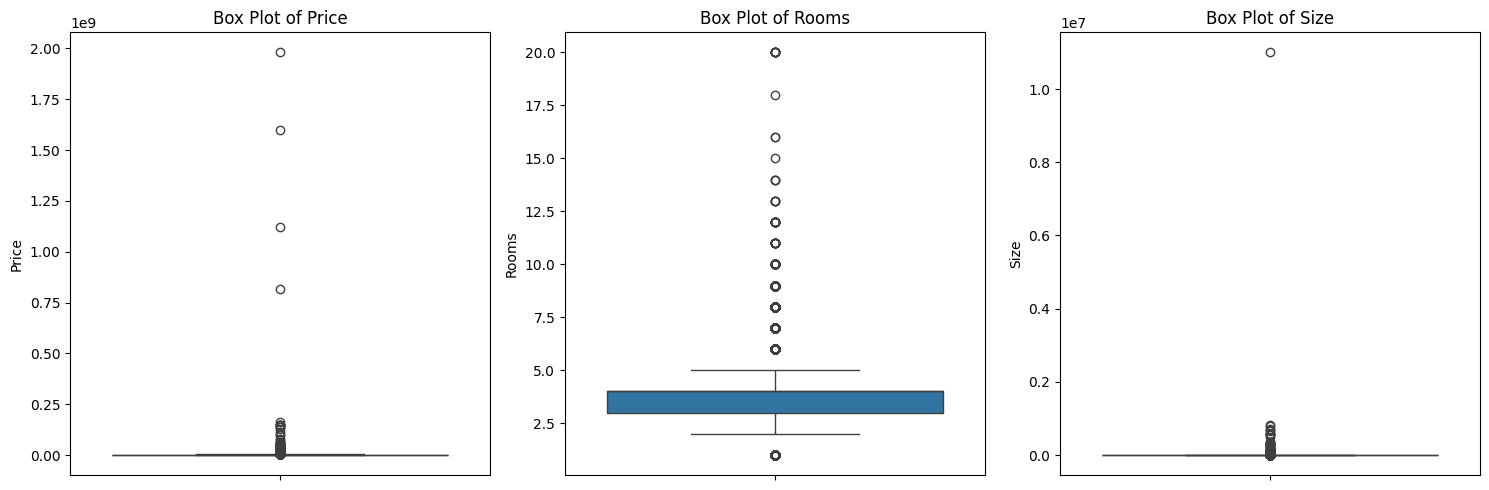

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Detect outliers using Z-Score
def detect_outliers_zscore(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = [(x - mean) / std for x in data]
    return np.where(np.abs(z_scores) > threshold)

# Detect outliers using IQR
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.where((data < lower_bound) | (data > upper_bound))

# Columns to check for outliers
numeric_columns = ['Price', 'Rooms', 'Size']

# Z-Score method
for col in numeric_columns:
    outliers_zscore = detect_outliers_zscore(df[col].dropna())
    print(f'Outliers detected in {col} using Z-Score method: {len(outliers_zscore[0])}')

# IQR method
for col in numeric_columns:
    outliers_iqr = detect_outliers_iqr(df[col].dropna())
    print(f'Outliers detected in {col} using IQR method: {len(outliers_iqr[0])}')

plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

#### 2.3.10 Handling Outliers

To ensure that our machine learning model is not adversely affected by extreme outliers, we implemented a two-step process: removing extreme outliers and capping remaining outliers. This process helps in maintaining the integrity and reliability of the data, leading to more accurate model predictions.

1. **Removing Extreme Outliers:**
Extreme outliers were identified using both the Z-Score method and the IQR method. Outliers detected by both methods were considered extreme and removed from the dataset.

2. **Capping Remaining Outliers:**
After removing extreme outliers, we capped the remaining outliers to the IQR bounds. This step ensures that the remaining data points lie within a reasonable range, reducing the impact of outliers on the model.

3. **Verifying Changes:**
To verify the effectiveness of our outlier handling steps, we re-evaluated the number of outliers in each numeric column using both the Z-Score method and the IQR method.

4. **Visualizing Post-Processed Data:**
Finally, we used box plots to visualize the data after handling outliers.

5. **Additional Information**:
Initially, we tried removing all outliers from the dataset by changing `outliers_zscore.intersection(outliers_iqr)` to `outliers_zscore.union(outliers_iqr)`. However, this approach resulted in lower accuracy for the machine learning model. This decrease in accuracy might be due to the fact that some outliers, while extreme, still carry important information about the variability and complexity of the data. It could be that by removing these outliers entirely, the model might lose valuable insights that contribute to its ability to generalize well to new data.

Outliers remaining in Price using Z-Score method: 0
Outliers remaining in Price using IQR method: 4827
Outliers remaining in Rooms using Z-Score method: 0
Outliers remaining in Rooms using IQR method: 0
Outliers remaining in Size using Z-Score method: 0
Outliers remaining in Size using IQR method: 0


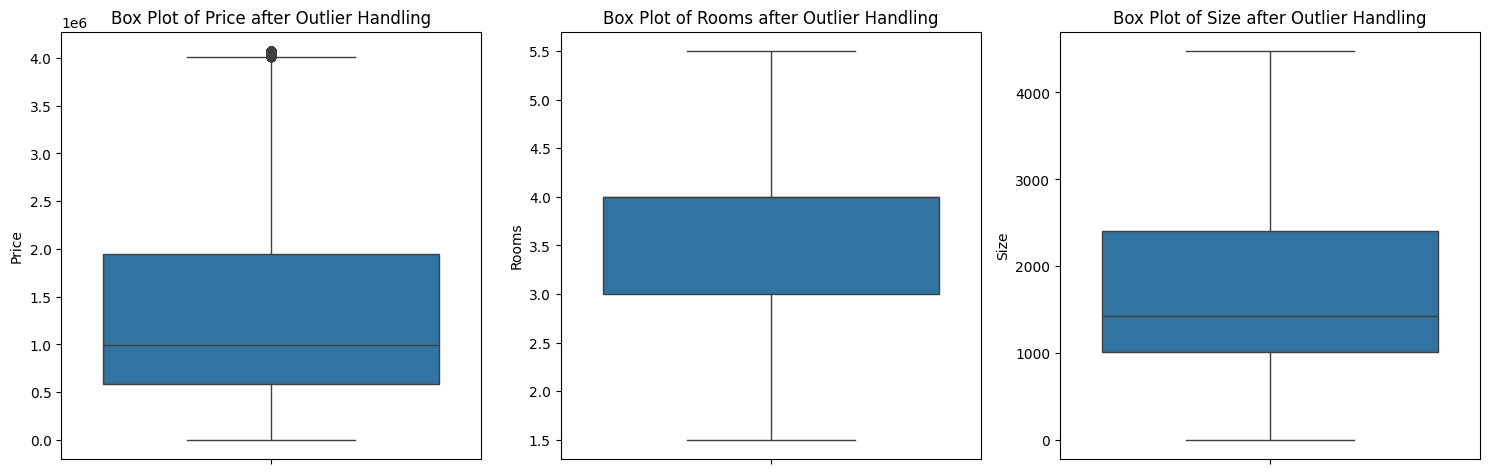

In [14]:
# Remove extreme outliers
def remove_extreme_outliers(df, col):
    outliers_zscore = set(detect_outliers_zscore(df[col].dropna())[0])
    outliers_iqr = set(detect_outliers_iqr(df[col].dropna())[0])
    extreme_outliers = outliers_zscore.intersection(outliers_iqr)
    return df.drop(index=df.iloc[list(extreme_outliers)].index)

# Cap remaining outliers to IQR bounds
def cap_outliers(df, col):
    Q1 = np.percentile(df[col].dropna(), 25)
    Q3 = np.percentile(df[col].dropna(), 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

for col in numeric_columns:
    df = remove_extreme_outliers(df, col)
    df = cap_outliers(df, col)

# Verify the changes 
for col in numeric_columns:
    outliers_zscore = detect_outliers_zscore(df[col].dropna())
    outliers_iqr = detect_outliers_iqr(df[col].dropna())
    print(f'Outliers remaining in {col} using Z-Score method: {len(outliers_zscore[0])}')
    print(f'Outliers remaining in {col} using IQR method: {len(outliers_iqr[0])}')

plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(df[col])
    plt.title(f'Box Plot of {col} after Outlier Handling')
plt.tight_layout()
plt.show()

#### 2.3.11 Handling Extremely Low Prices

To further refine our dataset, we decided to exclude entries with extremely low property prices. Properties priced below 100,000 which seems unrealistic and are potentially erroneous entries that could skew the model's predictions.

1. **Identifying Extremely Low Prices:**
We first identified and examined entries with property prices below 100,000. These entries were flagged for removal to maintain the integrity of our dataset.

2. **Removing Extremely Low Prices:**
We then filtered out these entries, retaining only those properties with prices equal to or greater than 100,000. This step ensures that our model is trained on data that accurately reflects the market.

3. **Verifying the Removal:**
After filtering, we verified that no entries with prices below 100,000 remained in the dataset.



In [15]:
df[df['Price'] < 100000]

Location   Price  Rooms  Bathrooms  Car Parks       Property Type  \
922             KLCC  1800.0    4.0        1.0        0.0  Serviced Residence   
923             KLCC  1800.0    4.0        1.0        0.0  Serviced Residence   
1196            KLCC  7500.0    2.0        2.0        1.0  Serviced Residence   
1878   BUKIT BINTANG  3000.0    1.5        1.0        1.0         Condominium   
2549            KLCC  8000.0    5.0        5.0        0.0  Serviced Residence   
...              ...     ...    ...        ...        ...                 ...   
52928   SRI PETALING  1500.0    3.0        2.0        1.0         Condominium   
52935   SRI PETALING  1100.0    3.0        2.0        1.0         Condominium   
52996        BANGSAR  3500.0    4.0        3.0        1.0         Condominium   
53095     MONT KIARA  4000.0    4.0        1.0        0.0  Serviced Residence   
53244     MONT KIARA  8000.0    4.0        4.0        0.0         Condominium   

         Size        Furnishing  
922     493.0  Partly Furnished  
923     493.0  Partly Furnished  
1196   1078.0   Fully Furnished  
1878    538.0   Fully Furnished  
2549   2096.0   Fully Furnished  
...       ...               ...  
52928   850.0  Partly Furnished  
52935   850.0  Partly Furnished  
52996  1300.0   Fully Furnished  
53095  1540.0   Fully Furnished  
53244  2243.0       Unfurnished  

[387 rows x 8 columns]

In [16]:
df = df[df['Price'] >= 100000]
df[df['Price'] < 100000]

Empty DataFrame
Columns: [Location, Price, Rooms, Bathrooms, Car Parks, Property Type, Size, Furnishing]
Index: []

In [17]:
df[df['Size'] < 400]

Location      Price  Rooms  Bathrooms  Car Parks  \
583           MONT KIARA  2340000.0    5.0        5.0        3.0   
584           MONT KIARA  1698000.0    4.0        4.0        2.0   
1473             KL CITY   319999.0    4.0        1.0        0.0   
1867          TAMAN DESA  1450000.0    4.0        3.0        2.0   
1881   DAMANSARA HEIGHTS  4072500.0    5.5        4.0        0.0   
...                  ...        ...    ...        ...        ...   
53191      DESA PARKCITY  1350000.0    4.0        3.0        2.0   
53193      DESA PARKCITY  1480000.0    4.0        3.0        2.0   
53194      DESA PARKCITY  1600000.0    4.0        3.0        1.0   
53213            KL CITY  1550000.0    3.0        3.0        2.0   
53436        BRICKFIELDS   303000.0    4.0        1.0        0.0   

                  Property Type   Size        Furnishing  
583                 Condominium    0.0  Partly Furnished  
584                 Condominium    0.0  Partly Furnished  
1473         Serviced Residence  351.0   Fully Furnished  
1867   2-sty Terrace/Link House   85.0       Unfurnished  
1881                   Bungalow   55.0  Partly Furnished  
...                         ...    ...               ...  
53191               Condominium    0.0  Partly Furnished  
53193  3-sty Terrace/Link House    0.0  Partly Furnished  
53194  3-sty Terrace/Link House    0.0  Partly Furnished  
53213        Serviced Residence    0.0   Fully Furnished  
53436        Serviced Residence  250.0   Fully Furnished  

[205 rows x 8 columns]

In [18]:
df = df[df['Size'] >= 450]
df[df['Size'] < 450]

Empty DataFrame
Columns: [Location, Price, Rooms, Bathrooms, Car Parks, Property Type, Size, Furnishing]
Index: []

#### 2.3.12 Saving the Cleaned Dataset

After performing the data cleaning steps, we saved the cleaned dataset to a CSV file. This step ensures that our cleaned data is stored and can be easily accessed for further analysis.

In [19]:
df.to_csv('data/cleaned_data.csv')

In [20]:
# Perform one-hot encoding on updated categorical variables
encoded_df = pd.get_dummies(df, columns=['Location', 'Property Type', 'Furnishing'], drop_first=False)

### 3 Data Manipulation

#### 3.1 One-Hot Encoding of Categorical Variables

To prepare the dataset for machine learning model training, we performed one-hot encoding on the categorical variables. One-hot encoding transforms categorical variables into a format that can be provided to machine learning algorithms to improve their performance.

1. **One-Hot Encoding of Categorical Variables:**
We applied one-hot encoding to the categorical columns: 'Location', 'Property Type', and 'Furnishing'. This transformation creates binary columns for each category in these variables, allowing the model to interpret them correctly.

2. **Saving the Encoded Dataset:**
The encoded dataset was saved to a CSV file named encoded_data.csv. This file will be used for training the machine learning model, ensuring that the categorical variables are in a suitable format for analysis.



In [21]:
encoded_df

Price  Rooms  Bathrooms  Car Parks    Size  \
0      1250000.0    3.0        3.0        2.0  1335.0   
1      4072500.0    5.5        7.0        0.0  4477.5   
2      1030000.0    3.0        4.0        2.0  1875.0   
4       900000.0    5.0        3.0        2.0  1513.0   
5      4072500.0    5.5        5.0        4.0  4477.5   
...          ...    ...        ...        ...     ...   
53878  4072500.0    5.5        4.0        0.0  4477.5   
53879  4072500.0    5.0        4.0        0.0  4477.5   
53880  4072500.0    5.5        4.0        0.0  4477.5   
53881   480000.0    3.0        2.0        0.0  1150.0   
53882   540000.0    4.0        2.0        3.0  1313.0   

       Location_ADIVA DESA PARKCITY  Location_ALAM DAMAI  Location_AMPANG  \
0                             False                False            False   
1                             False                False            False   
2                             False                False            False   
4                             False                False            False   
5                             False                False            False   
...                             ...                  ...              ...   
53878                         False                False            False   
53879                         False                False            False   
53880                         False                False            False   
53881                         False                False            False   
53882                         False                False            False   

       Location_AMPANG HILIR  Location_BANDAR DAMAI PERDANA  ...  \
0                      False                          False  ...   
1                      False                          False  ...   
2                      False                          False  ...   
4                      False                          False  ...   
5                      False                          False  ...   
...                      ...                            ...  ...   
53878                  False                          False  ...   
53879                  False                          False  ...   
53880                  False                          False  ...   
53881                  False                          False  ...   
53882                  False                          False  ...   

       Property Type_Bungalow  Property Type_Condominium  Property Type_Flat  \
0                       False                      False               False   
1                        True                      False               False   
2                       False                       True               False   
4                       False                       True               False   
5                        True                      False               False   
...                       ...                        ...                 ...   
53878                    True                      False               False   
53879                    True                      False               False   
53880                    True                      False               False   
53881                   False                       True               False   
53882                   False                       True               False   

       Property Type_Residential Land  Property Type_Semi-detached House  \
0                               False                              False   
1                               False                              False   
2                               False                              False   
4                               False                              False   
5                               False                              False   
...                               ...                                ...   
53878                           False                              False   
53879          

In [22]:
encoded_df.to_csv('data/encoded_data.csv', index=False)

## 6 Predictive Analysis

### 6.1 Importing Libraries
We imported the necessary libraries for model training and evaluation, including `joblib` for model saving, `pandas` and `numpy` for data manipulation, and `scikit-learn` for model building and evaluation.

In [23]:
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

### 6.2 Model Training

#### 6.2.1 Linear Regression

1. **Preparing the Data:**
We split the encoded dataset into training and testing sets. The target variable 'Price' was separated from the feature set.

2. **Training the Linear Regression Model:**
We trained a Linear Regression model on the training data and evaluated its performance on both the training and testing sets.

3. **Cross-Validation:**
We performed cross-validation using 5-fold splits to ensure the stability and robustness of the Linear Regression model.

In [24]:
X = encoded_df.drop(columns=['Price'])
y = encoded_df['Price']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

linear_model_train_score = linear_model.score(X_train, y_train)
linear_model_test_score = linear_model.score(X_test, y_test)
print(f"Linear Regression Training score: {linear_model_train_score}")
print(f"Linear Regression Testing score: {linear_model_test_score}")

# Cross-Validation for Linear Regression
kf = KFold(n_splits=5, shuffle=True, random_state=42)
linear_cv_scores = cross_val_score(linear_model, X, y, cv=kf, scoring='r2')
print(f"Linear Regression Cross-Validation scores: {linear_cv_scores}")
print(f"Linear Regression Cross-Validation Mean score: {np.mean(linear_cv_scores)}")

Linear Regression Training score: 0.8683020545891691
Linear Regression Testing score: 0.8628822526683465
Linear Regression Cross-Validation scores: [0.86288225 0.86733917 0.86428863 0.86727209 0.87025196]
Linear Regression Cross-Validation Mean score: 0.8664068183586087


These results indicate that the Linear Regression model has performed well. The high training score of 0.8683 and testing score of 0.8629 suggest that the model is able to capture the relationship between the features and the target variable 'Price' effectively. Also, the close values of the training and testing scores also suggest that the model is not overfitting and generalizes well to unseen data.

The cross-validation scores, which range from 0.8629 to 0.8703, with a mean score of 0.8664, further confirm the model's robustness. The consistency across the cross-validation folds indicates that the model's performance is stable and reliable across different subsets of the data.

#### 6.2.2 Analysis of Prediction Errors of the Linear Regression model

1. **Making Predictions:**
The model's predictions on the testing set were compared to the actual values to assess performance. We calculated the prediction errors and visualized their distribution.

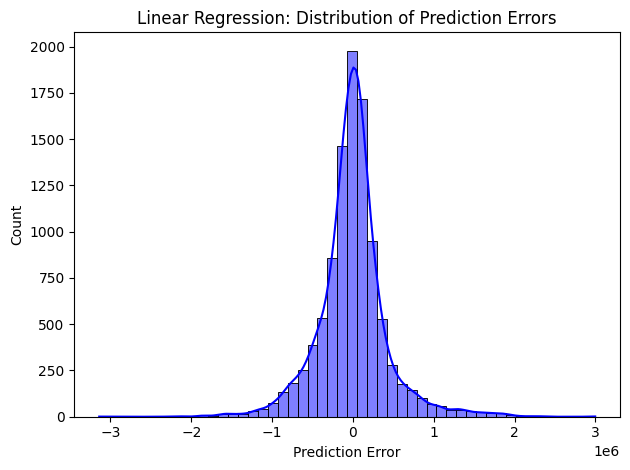

In [27]:
# Predictions
y_pred_linear = linear_model.predict(X_test)

errors_lr = y_test - y_pred_linear

sns.histplot(errors_lr, bins=50, kde=True, color='blue')
plt.xlabel("Prediction Error")
plt.title("Linear Regression: Distribution of Prediction Errors")

plt.tight_layout()
plt.show()

**Centering Around Zero:**
The prediction errors are centered around zero, indicating that the Linear Regression model has minimal bias. This means that the model's predictions are, on average, very close to the actual values.

**Symmetrical Distribution:**
The symmetrical shape of the error distribution suggests that the errors are normally distributed. This is a good sign as it indicates that the model's errors are evenly spread out, without significant skewness or bias towards overestimating or underestimating property prices.

**Majority of Errors Close to Zero Area:**
The highest concentration of errors is near zero, meaning that most of the model's predictions are quite accurate. The density of the errors decreases as we move further away from zero, which is expected in a well-performing model.

From this, we learnt that the distribution of prediction errors indicates that the Linear Regression model performs well, with most errors being small and centered around zero. The normal distribution of errors and the symmetry around zero suggest that the model is making unbiased predictions with reasonable accuracy.

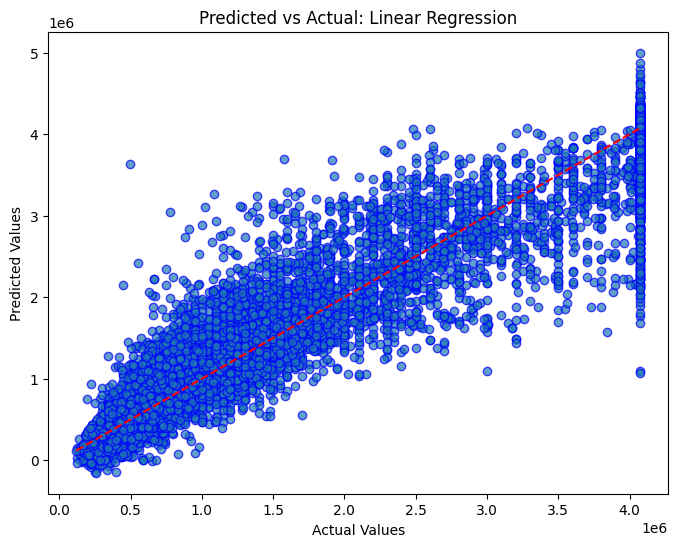

In [28]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_linear, alpha=0.7, edgecolors='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual: Linear Regression')
plt.show()

This scatter plot provides a visual representation of the performance of the linear regression model in predicting values. 

1. **Deviation from Ideal Line:** There is a noticeable spread around the ideal line. This spread represents the error in predictions. The closer the points are to the red line, the more accurate the predictions are. The points are more scattered as the actual values increases which may suggest that the model's accuracy may decrease for larger actual values.

2. **Data Distribution:** The density of points is higher at lower values which suggests that the dataset contains more observations with lower actual values. At the higher end of the actual values, the points are sparser which suggesting fewer observations in this area.

3. **Prediction Range:** The model predicts a wide range of values, but there is a noticeable vertical line of points at the high end of the actual values around 4.0^6. This indicates that for these high actual values, the model's predictions are somewhat constant, which may point to a limitation in the model's ability to predict higher values accurately.

In [29]:
mae_lr = mean_absolute_error(y_test, y_pred_linear)
mse_lr = mean_squared_error(y_test, y_pred_linear)
rmse_lr = np.sqrt(mse_lr)

print("Linear Regression Performance:")
print(f"MAE: {mae_lr}")
print(f"MSE: {mse_lr}")
print(f"RMSE: {rmse_lr}")

Linear Regression Performance:
MAE: 290168.2889183142
MSE: 186405552652.17422
RMSE: 431747.0933916918


The Mean Absolute Error (MAE) of the Linear Regression model was 290168.29. This metric measures the average magnitude of the errors in the predictions, without considering their direction. It represents the average absolute difference between the predicted and actual values. An MAE of 290168.29 indicates that, on average, the model's predictions are off by this amount.

The Mean Squared Error (MSE) was found to be 18640555252.17. MSE measures the average of the squares of the errors, giving higher weight to larger errors, which makes it useful for identifying models with significant outliers. The MSE value reflects the extent to which the model's predictions deviate from the actual values.

The Root Mean Squared Error (RMSE) was found to be 431747.09. RMSE is the square root of MSE and provides a measure of the average magnitude of the errors in the same units as the target variable. An RMSE of 431747.09 means that the model's predictions deviate from the actual values by this amount, on average.

#### 6.2.3 Random Forest Regressor Model
To test out other model's prediction capabilities, we trained a Random Forest Regressor. This section outlines the process of training, evaluating, and cross-validating the Random Forest Regressor model.

1. **Preparing and Standardizing the Data:**
We standardized the features to ensure that each feature contributes equally to the model, preventing features with larger scales from dominating.

2. **Training the Random Forest Regressor Model:**
We trained a Random Forest Regressor with 100 estimators on the scaled training data and evaluated its performance on both the training and testing sets.

In [30]:
# Random Forest Regressor Model
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

rf_model_train_score = rf_model.score(X_train_scaled, y_train)
rf_model_test_score = rf_model.score(X_test_scaled, y_test)

print(f"Random Forest training score: {rf_model_train_score}")
print(f"Random Forest testing score: {rf_model_test_score}")

Random Forest training score: 0.9831898994849854
Random Forest testing score: 0.9391420637862543


In [31]:
rf_cv_scores = cross_val_score(rf_model, X_scaled, y, cv=kf, scoring='r2')
print(f"Random Forest Cross-Validation scores: {rf_cv_scores}")
print(f"Random Forest Cross-Validation Mean score: {np.mean(rf_cv_scores)}")

Random Forest Cross-Validation scores: [0.93928963 0.94050332 0.94113998 0.94333932 0.94150993]
Random Forest Cross-Validation Mean score: 0.9411564351099505


The Random Forest Regressor achieved a high training score of 0.9832, showing that the model fits the training data very well and captures the underlying patterns effectively.

The testing score of 0.9391 suggests that the model generalizes well to unseen data. This strong performance on the testing set indicates that the Random Forest Regressor maintains its predictive accuracy when applied to unseen data.

In addition, cross-validation was performed to further assess the model's stability and consistency. The cross-validation scores ranged from 0.9393 to 0.9433, reflecting the model's consistent performance across different subsets of the data. The mean cross-validation score of 0.9412 confirms that the Random Forest Regressor consistently provides reliable predictions, with minimal variance between the different folds.

Overall, the Random Forest Regressor demonstrated outstanding performance with a high training score of 0.9832 and a robust testing score of 0.9391. The cross-validation scores further validate its reliability and stability, with a mean score of 0.9412. These results indicate that the Random Forest Regressor is highly effective for predicting property prices, providing accurate and consistent predictions across different data subsets.

#### 6.2.4 Analysis of Prediction Errors of the Random Forest Regressor model

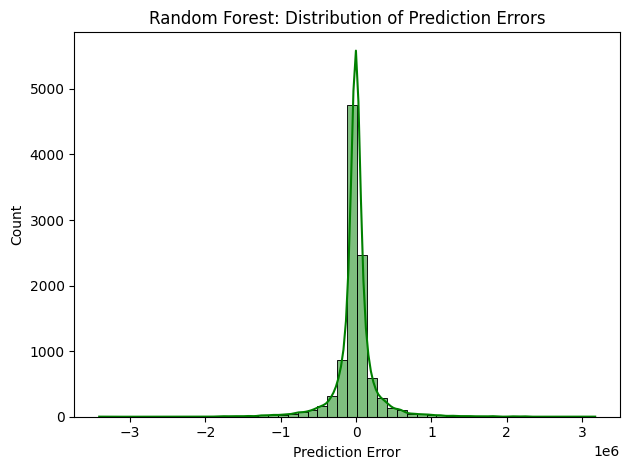

In [32]:
# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
errors_rf = y_test - y_pred_rf

sns.histplot(errors_rf, bins=50, kde=True, color='green')
plt.xlabel("Prediction Error")
plt.title("Random Forest: Distribution of Prediction Errors")

plt.tight_layout()
plt.show()

**Centering Around Zero:**
The prediction errors are centered around the zero area, indicating that the Random Forest Regressor has minimal bias. This suggests that the model's predictions are on average very close to the actual values, showing its accuracy in capturing the true property prices.

**Narrow Distribution:**
The narrow and sharp peak of the error distribution suggests that the majority of the model's predictions have very small errors. This indicates high precision, as most predictions are closely aligned with the actual values.

**Symmetrical Shape:**
The symmetrical shape of the error distribution around zero indicates that the errors are normally distributed. This suggests that the model's errors are evenly spread out, without significant skewness or bias towards overestimating or underestimating property prices.

**Error Spread:**
The spread of errors is very narrow, with most errors concentrated around zero and only a few deviating significantly. This tight clustering of errors further emphasizes the model's accuracy and robustness.

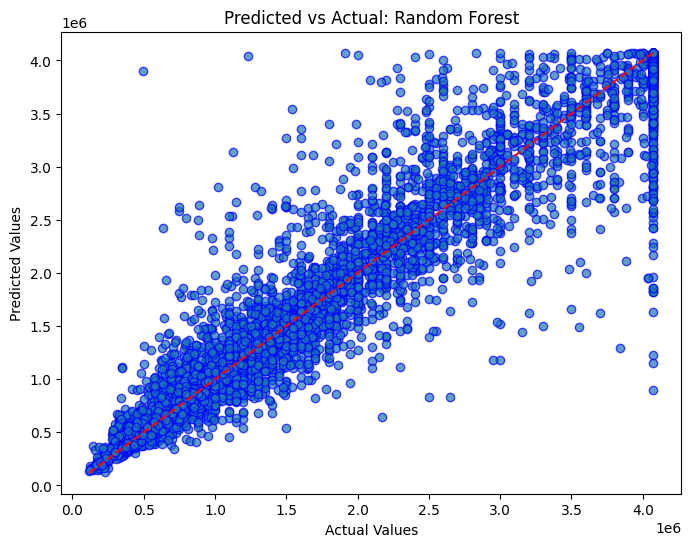

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7, edgecolors='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual: Random Forest')
plt.show()

This scatter plot provides a visual representation of the performance of the random forest regressor model in predicting values. 

1. **Deviation from Ideal Line:** The majority of the points are closely aligned with the diagonal line, particularly for lower and mid-range property values. This suggests that the model's predictions are very accurate for these values, deviating minimally from the actual prices. As property values increase, the deviation from the ideal line becomes greater. This indicates that while the model is generally accurate, its predictions for higher-priced properties exhibit more variability.

2. **Data Distribution:** There is a dense clustering of points around the ideal line, especially in the lower and middle price ranges. This concentration indicates that the model performs well in predicting property prices that fall within these ranges, with predictions closely matching actual values. The points are more spread out for higher property values, indicating a wider range of prediction errors. This spread suggests that the model's precision decreases slightly as the property prices increase

3. **Prediction Range:** The model maintains a consistent trend of predictions aligning with actual values. This consistency indicates that the model is can generalize well across different price ranges. A few points are significantly distant from the ideal line, indicating instances where the model's predictions deviate substantially from the actual values.

In [34]:
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print("\nRandom Forest Performance:")
print(f"MAE: {mae_rf}")
print(f"MSE: {mse_rf}")
print(f"RMSE: {rmse_rf}")


Random Forest Performance:
MAE: 144069.69577736457
MSE: 82733690233.0748
RMSE: 287634.64713604096


The Mean Absolute Error (MAE) of the Random Forest Regressor model was 144069.70. MAE measures the average magnitude of the errors in the predictions, without considering their direction. Essentially, it represents the average absolute difference between the predicted and actual values. An MAE of 144069.70 indicates that, on average, the model's predictions are off by this amount, demonstrating a high level of precision.

The Mean Squared Error (MSE) was found to be 82733690233.07. MSE measures the average of the squares of the errors, giving higher weight to larger errors, which makes it useful for identifying models with significant outliers. The MSE value reflects the extent to which the model's predictions deviate from the actual values.

The Root Mean Squared Error (RMSE) was calculated to be 287634.65. RMSE is the square root of MSE and provides a measure of the average magnitude of the errors in the same units as the target variable. An RMSE of 287634.65 means that the model's predictions deviate from the actual values by this amount, on average. This lower RMSE compared to MAE further confirms the model's accuracy and reliability.

### 6.3 Comparison between Linear Regression Model and Random Forest Regressor Model

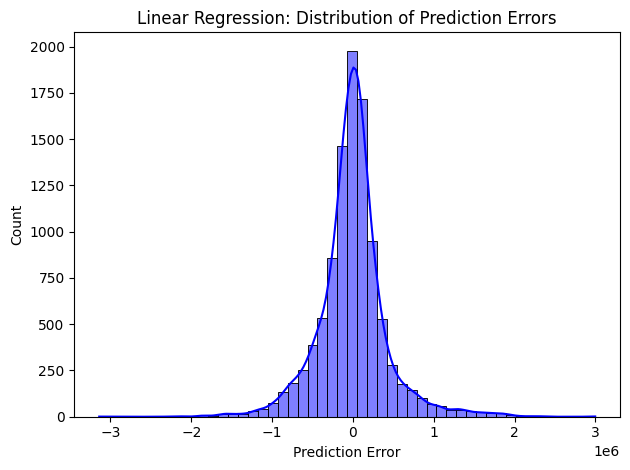
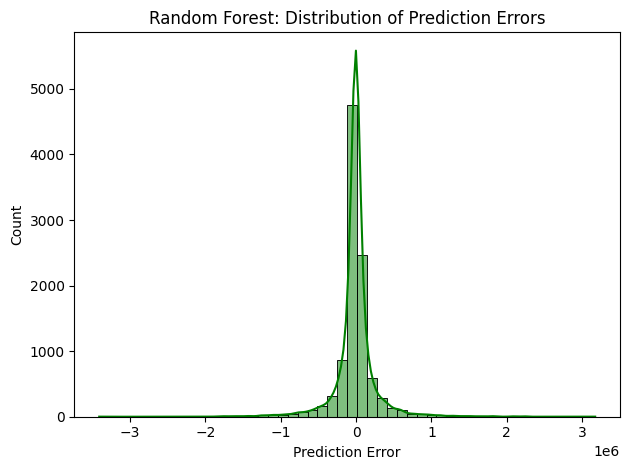

Table of Comparison of Distribution of Prediction Errors of Linear Regression vs Random Forest Regressor

| Aspect                   | Linear Regression                               | Random Forest Regressor                       |
|--------------------------|-------------------------------------------------|-----------------------------------------------|
| Centering Around Zero    | Centered around zero                            | Centered around zero                          |
| Shape of Distribution    | Symmetrical, normal distribution                | Very narrow, sharp peak                       |
| Concentration of Errors  | High concentration around zero                  | Very high concentration around zero           |
| Density of Errors        | Moderate density decrease away from center      | Steep density decrease away from center       |
| Presence of Outliers     | Some outliers present in tails                  | Fewer outliers present in tails               |
| Precision in Predictions | Moderate precision with broader error spread    | Higher precision with narrow error spread     |
| Overall Accuracy         | Good accuracy with some variability             | Higher accuracy with minimal variability      |


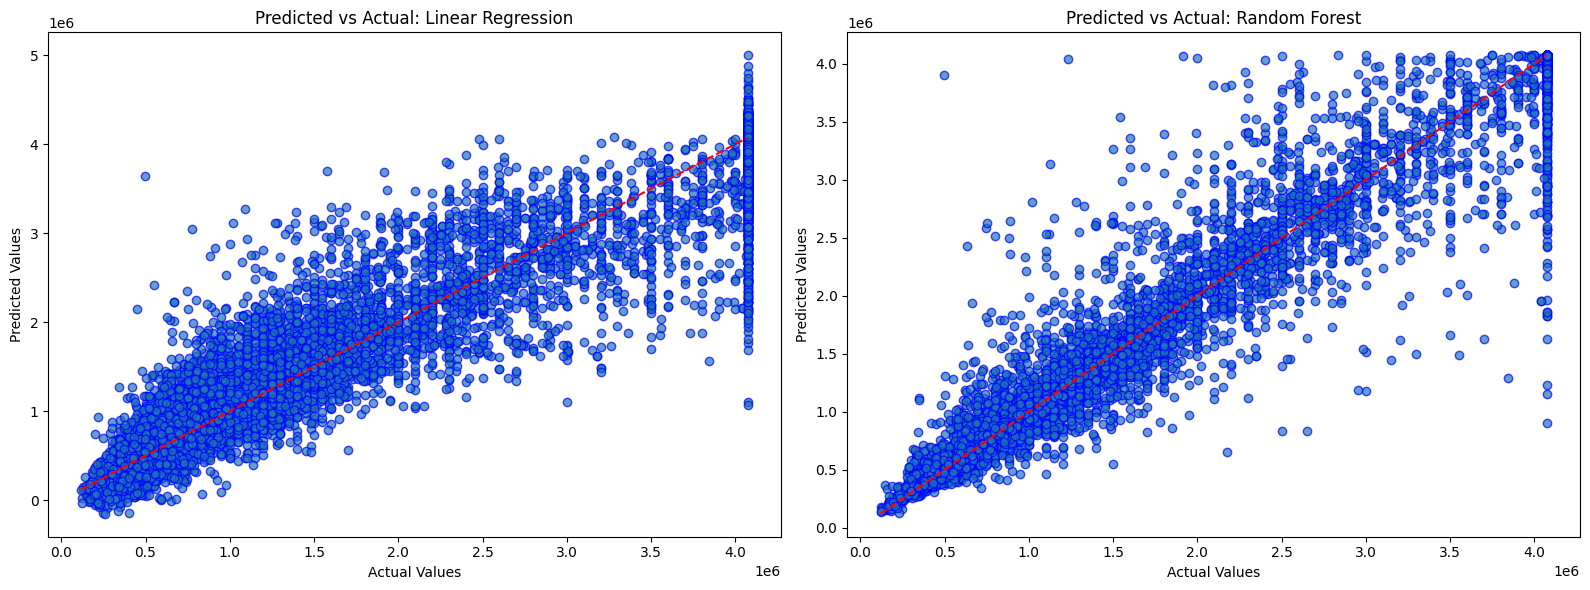

In [35]:
# Plotting Predicted vs Actual Values
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_linear, alpha=0.7, edgecolors='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual: Linear Regression')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.7, edgecolors='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual: Random Forest')

plt.tight_layout()
plt.show()

Table of Comparison of Predicted vs Actual Values: Linear Regression vs Random Forest Regressor

| Aspect                        | Linear Regression                                             | Random Forest Regressor                              |
|-------------------------------|---------------------------------------------------------------|------------------------------------------------------|
| Alignment with Ideal Line     | Deviates more from the ideal line, especially for higher values| Closely follows the ideal line, better alignment     |
| Concentration of Points       | Widely scattered around the ideal line                        | Densely clustered around the ideal line              |
| Spread of Predictions         | Broader spread, more variability                              | Narrower spread, less variability                    |
| Performance on Higher Values  | Greater deviation and scatter                                 | Closer alignment, better performance on higher values|
| Outliers Presence             | More outliers, especially for high values                     | Fewer outliers, tighter clustering                   |
| Overall Accuracy              | Good, but with more variability and outliers                  | High accuracy, less variability, and fewer outliers  |


### 6.4 Choosing the model

Therefore, based on these comparisons between Linear Regression model and the Random Forest Regressor model, we have chosen the Random Forest Regressor as our house price prediction model. The Random Forest model provides a higher accuracy, with a narrow spread of errors and a sharp peak around the zero area in the distribution of prediction errors. This high level of precision and minimal variability makes it a more suitable choice for predicting house prices.

Finally, the Random Forest Regressor is trained on the entire dataset. This allows the model to learn from all the data points, improving its generalization ability for future predictions. 

In [36]:
# Fit the Random Forest model on the entire dataset
rf_model.fit(X_scaled, y)

RandomForestRegressor(random_state=42)

### 6.5 Preparation for Deployment

#### 6.5.1 Saving the Trained Model

After training the Random Forest Regressor on the entire dataset, we proceeded to save the trained model, the scaler, and the feature columns. This step ensures that the model and necessary preprocessing steps can be easily loaded and utilized in our Streamlit application.

In [37]:
# Save the trained model and scaler
joblib.dump(rf_model, 'joblibs/rf_model.joblib')
joblib.dump(scaler, 'joblibs/scaler.joblib')
joblib.dump(X.columns, 'joblibs/feature_columns.joblib')

['joblibs/feature_columns.joblib']

#### 6.5.2 Compressing the Model File for Storage

Given the large size of the dataset and the resulting model file, we needed to compress the model to store it in our GitHub repository. This compression step is important because the dataset is quite large, and compressing the model allows us to stay within the file size limits imposed by GitHub. This ensures that the model can be stored, versioned, and shared efficiently in our repository.

We used libraries such as `gzip` and `shutil` to compress the saved model file.

In [38]:
import gzip
import shutil

# Compress model file
def compress_model(input_file, output_file):
    with open(input_file, 'rb') as f_in:
        with gzip.open(output_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

compress_model('joblibs/rf_model.joblib', 'joblibs/rf_model.joblib.gz')

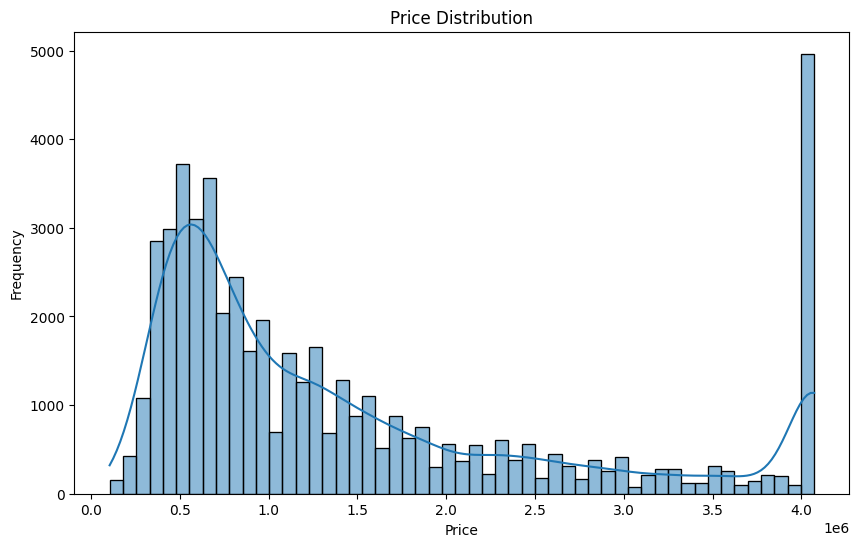

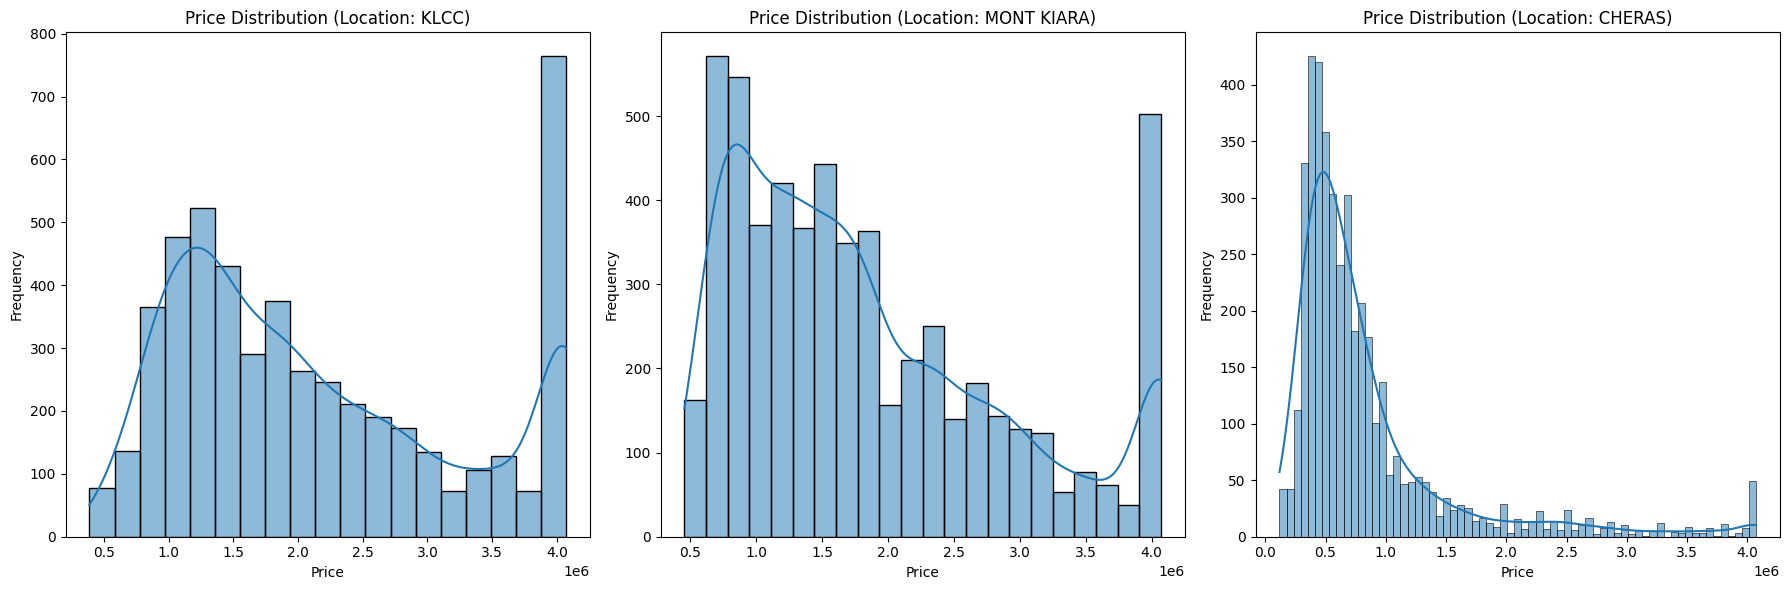

In [39]:
df_klcc = df[df['Location'] == 'KLCC']
df_kiara = df[df['Location'] == 'MONT KIARA']
df_cheras = df[df['Location'] == 'CHERAS']


# Histogram for price distribution for all locations
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


# Create a figure with three subplots for price distribution of three selected locations.
fig, axs = plt.subplots(1, 3, figsize=(18, 6))


# KLCC price distribution
sns.histplot(df_klcc['Price'], kde=True, ax=axs[0])
axs[0].set_title('Price Distribution (Location: KLCC)')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Frequency')


# MONT KIARA price distribution
sns.histplot(df_kiara['Price'], kde=True, ax=axs[1])
axs[1].set_title('Price Distribution (Location: MONT KIARA)')
axs[1].set_xlabel('Price')
axs[1].set_ylabel('Frequency')


# CHERAS price distribution
sns.histplot(df_cheras['Price'], kde=True, ax=axs[2])
axs[2].set_title('Price Distribution (Location: CHERAS)')
axs[2].set_xlabel('Price')
axs[2].set_ylabel('Frequency')


# Adjust layout
plt.tight_layout()


# Show the plot
plt.show()



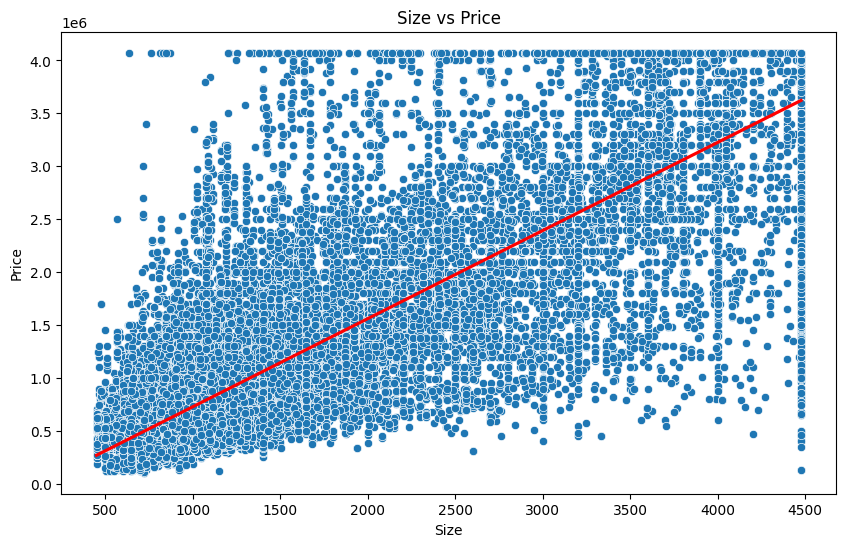

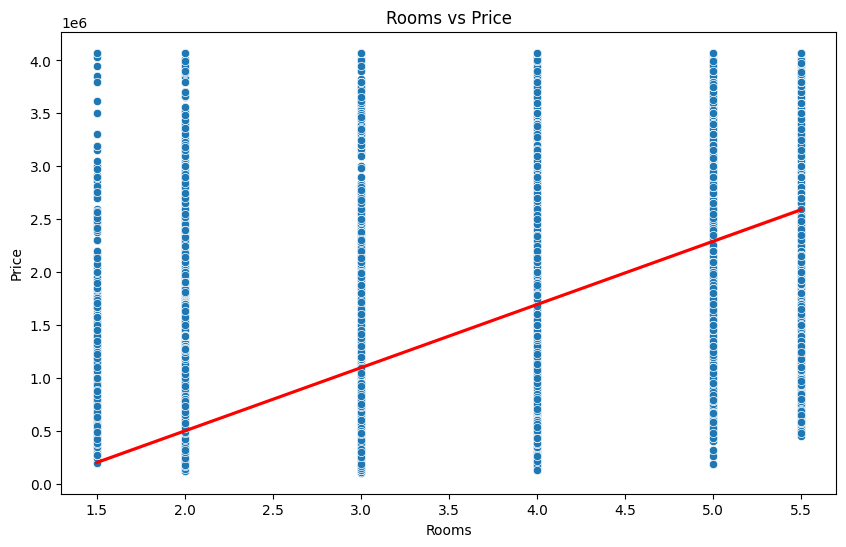

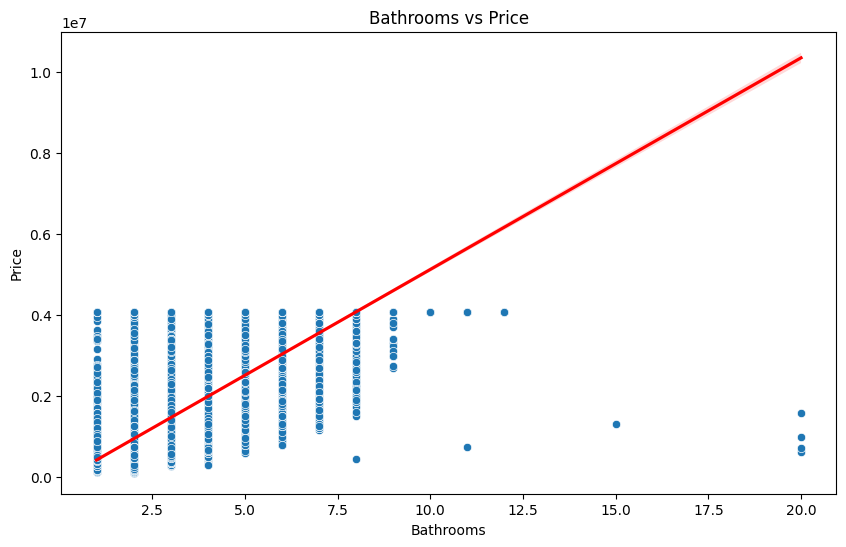

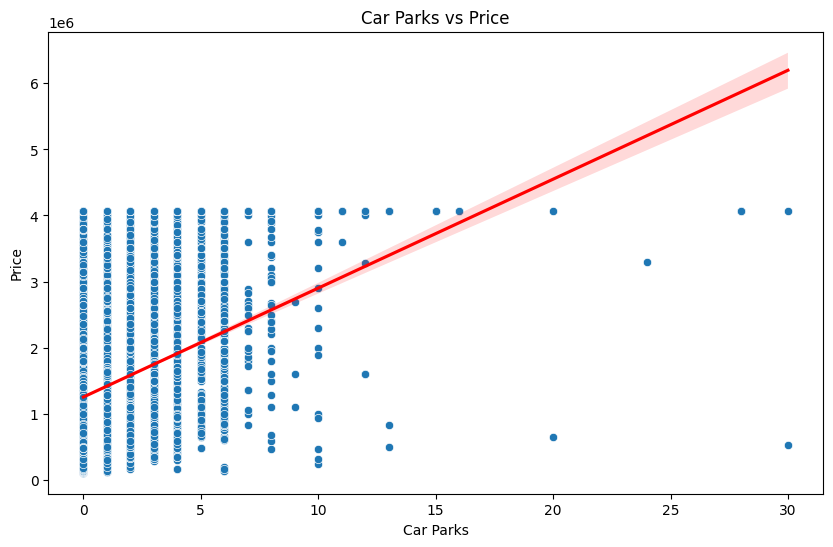

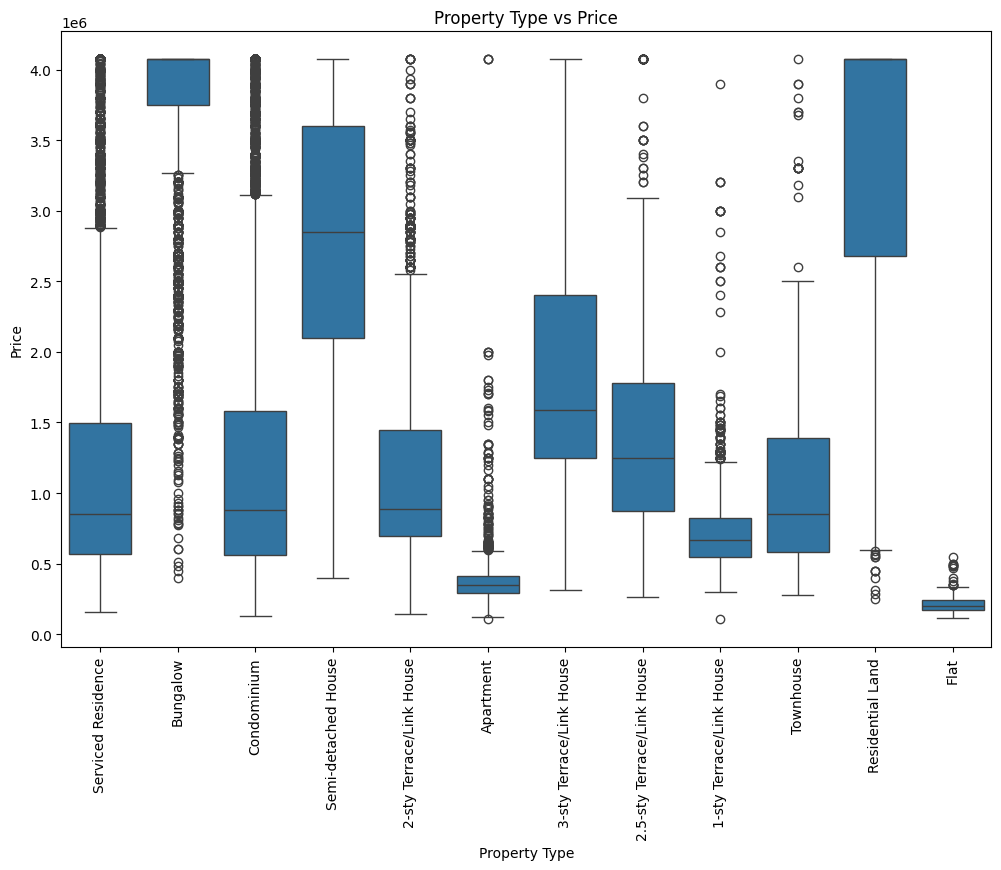

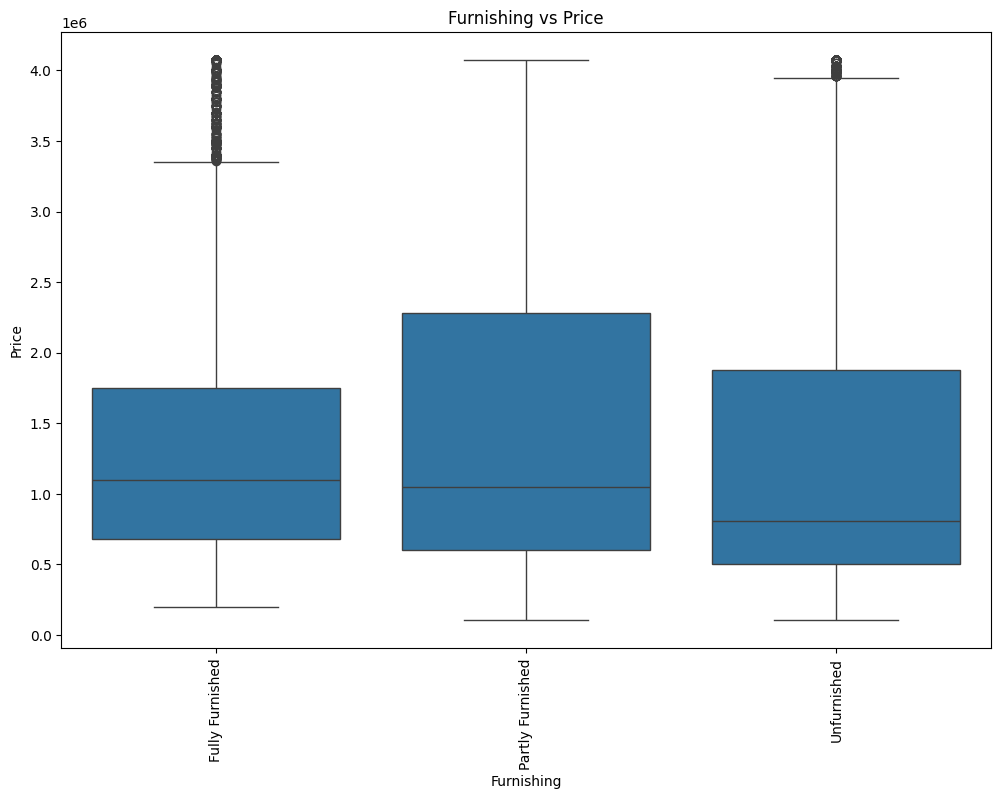

In [40]:
#scatter plot for Size vs Price for all location
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Size'], y=df['Price'])
sns.regplot(x=df['Size'], y=df['Price'], scatter=False, color='red')
plt.title('Size vs Price')
plt.xlabel('Size')
plt.ylabel('Price')
plt.show()




# Scatter plot for Rooms vs Price for all locations
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Rooms'], y=df['Price'])
sns.regplot(x=df['Rooms'], y=df['Price'], scatter=False, color='red')
plt.title('Rooms vs Price')
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.show()


# Scatter plot for Bathrooms vs Price for all locations
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Bathrooms'], y=df['Price'])
sns.regplot(x=df['Bathrooms'], y=df['Price'], scatter=False, color='red')
plt.title('Bathrooms vs Price')
plt.xlabel('Bathrooms')
plt.ylabel('Price')
plt.show()


# Scatter plot for Car Parks vs Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Car Parks'], y=df['Price'])
sns.regplot(x=df['Car Parks'], y=df['Price'], scatter=False, color='red')
plt.title('Car Parks vs Price')
plt.xlabel('Car Parks')
plt.ylabel('Price')
plt.show()


# Box plot for Property Type vs. Price
plt.figure(figsize=(12, 8))
sns.boxplot(x=df['Property Type'], y=df['Price'])
plt.title('Property Type vs Price')
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()


# Box plot for Furnishing vs Price
plt.figure(figsize=(12, 8))
sns.boxplot(x=df['Furnishing'], y=df['Price'])
plt.title('Furnishing vs Price')
plt.xlabel('Furnishing')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()

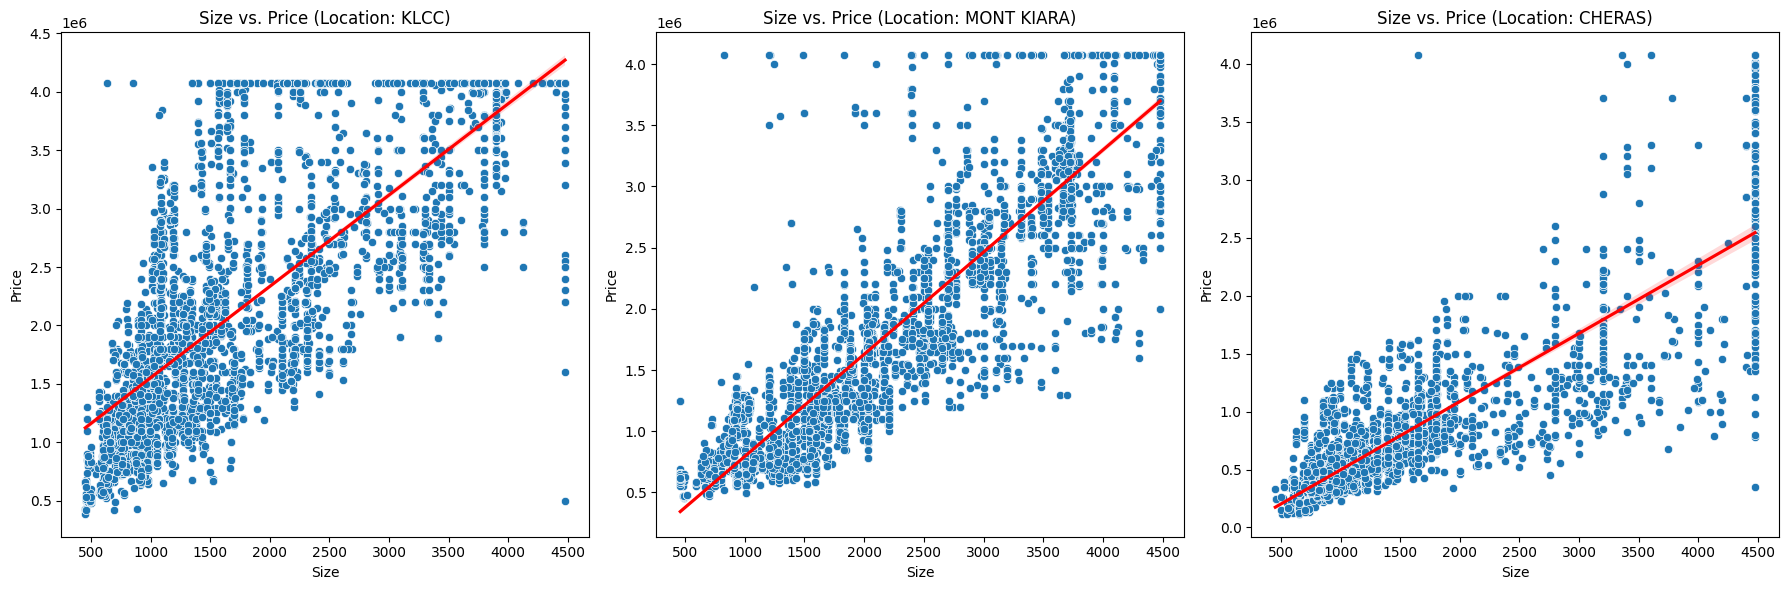

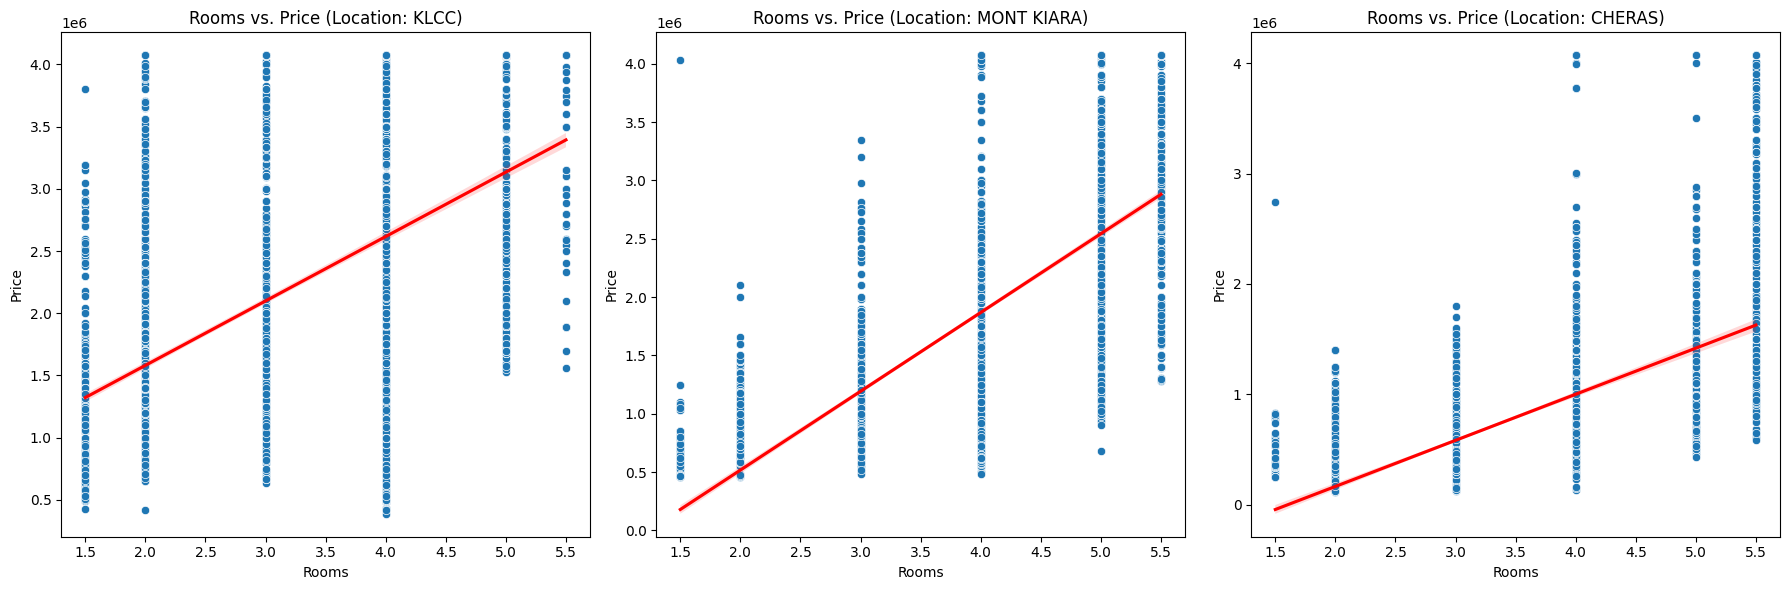

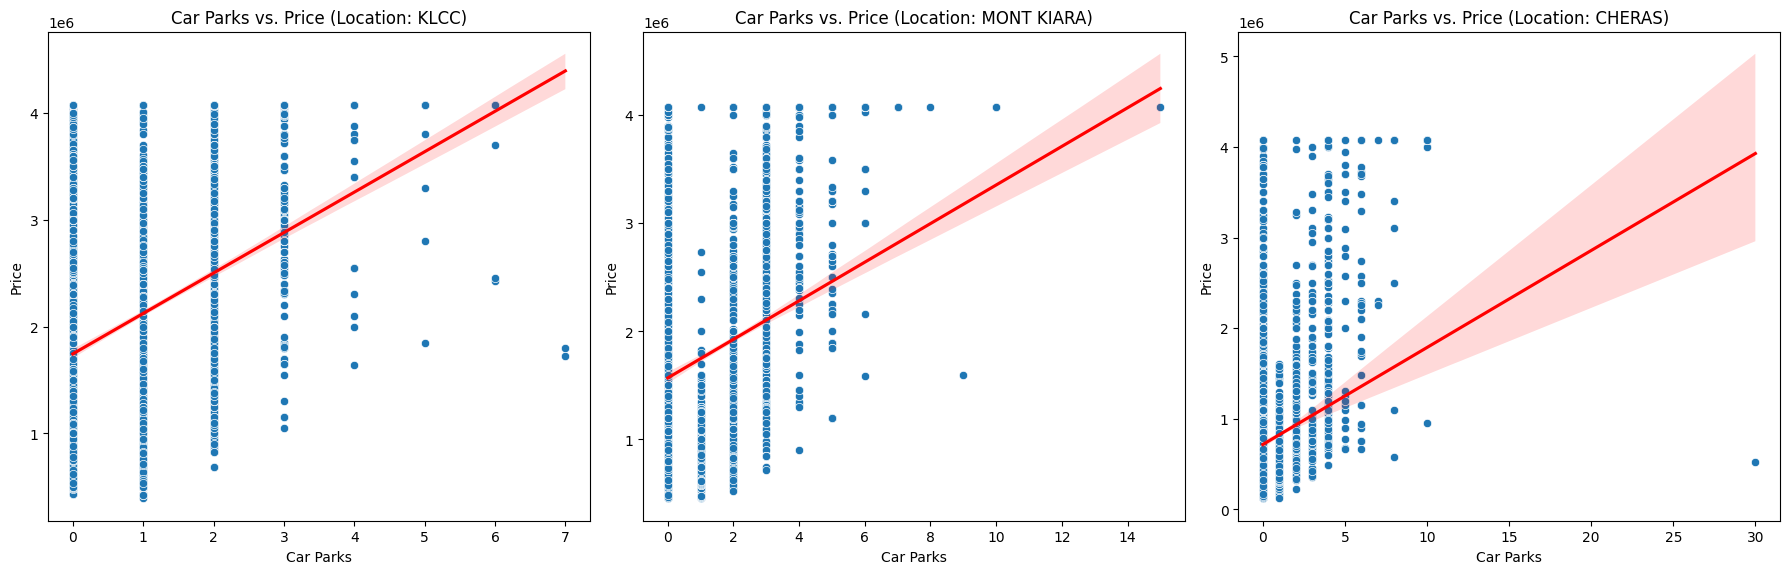

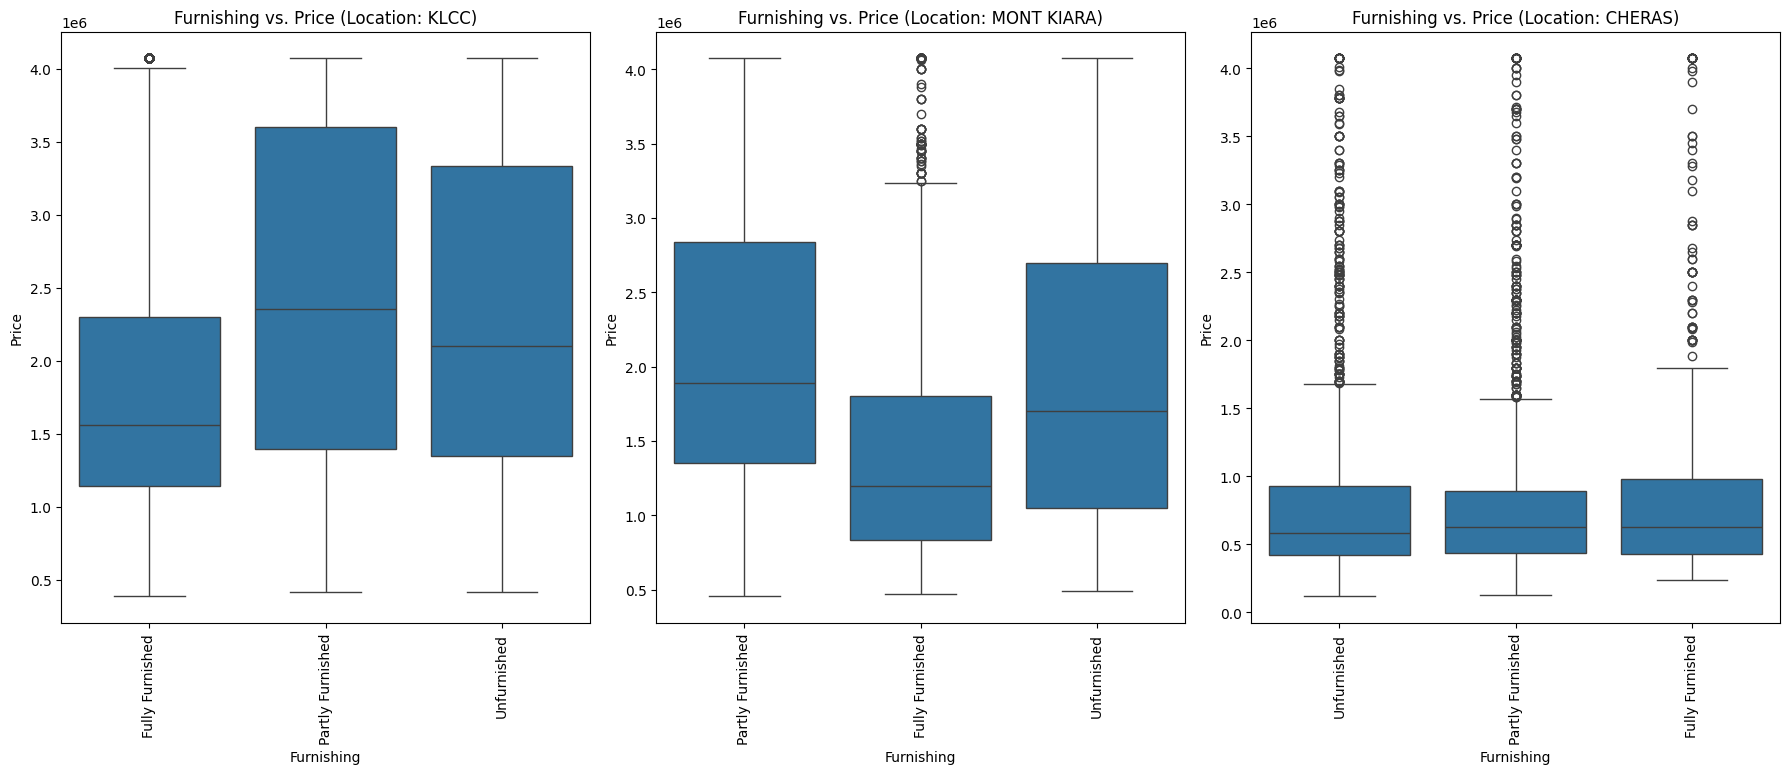

In [41]:
# Filter the data for the specific locations
df_klcc = df[df['Location'] == 'KLCC']
df_kiara = df[df['Location'] == 'MONT KIARA']
df_cheras = df[df['Location'] == 'CHERAS']


# Filter the data for the specific locations
df_klcc = df[df['Location'] == 'KLCC']
df_kiara = df[df['Location'] == 'MONT KIARA']
df_cheras = df[df['Location'] == 'CHERAS']


# Create a figure with three subplots for graph size vs. price
fig, axs = plt.subplots(1, 3, figsize=(18, 6))


# Scatter plot for Size vs. Price with Location = 'KLCC'
sns.scatterplot(ax=axs[0], x=df_klcc['Size'], y=df_klcc['Price'])
sns.regplot(ax=axs[0], x=df_klcc['Size'], y=df_klcc['Price'], scatter=False, color='red')
axs[0].set_title('Size vs. Price (Location: KLCC)')
axs[0].set_xlabel('Size')
axs[0].set_ylabel('Price')


# Scatter plot for Size vs. Price with Location = 'MONT KIARA'
sns.scatterplot(ax=axs[1], x=df_kiara['Size'], y=df_kiara['Price'])
sns.regplot(ax=axs[1], x=df_kiara['Size'], y=df_kiara['Price'], scatter=False, color='red')
axs[1].set_title('Size vs. Price (Location: MONT KIARA)')
axs[1].set_xlabel('Size')
axs[1].set_ylabel('Price')


# Scatter plot for Size vs. Price with Location = 'CHERAS'
sns.scatterplot(ax=axs[2], x=df_cheras['Size'], y=df_cheras['Price'])
sns.regplot(ax=axs[2], x=df_cheras['Size'], y=df_cheras['Price'], scatter=False, color='red')
axs[2].set_title('Size vs. Price (Location: CHERAS)')
axs[2].set_xlabel('Size')
axs[2].set_ylabel('Price')


# Adjust layout
plt.tight_layout()


# Show the plot
plt.show()


# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))


# Scatter plot for Rooms vs. Price with Location = 'KLCC'
sns.scatterplot(ax=axs[0], x=df_klcc['Rooms'], y=df_klcc['Price'])
sns.regplot(ax=axs[0], x=df_klcc['Rooms'], y=df_klcc['Price'], scatter=False, color='red')
axs[0].set_title('Rooms vs. Price (Location: KLCC)')
axs[0].set_xlabel('Rooms')
axs[0].set_ylabel('Price')


# Scatter plot for Rooms vs. Price with Location = 'MONT KIARA'
sns.scatterplot(ax=axs[1], x=df_kiara['Rooms'], y=df_kiara['Price'])
sns.regplot(ax=axs[1], x=df_kiara['Rooms'], y=df_kiara['Price'], scatter=False, color='red')
axs[1].set_title('Rooms vs. Price (Location: MONT KIARA)')
axs[1].set_xlabel('Rooms')
axs[1].set_ylabel('Price')


# Scatter plot for  vs. Price with Location = 'CHERAS'
sns.scatterplot(ax=axs[2], x=df_cheras['Rooms'], y=df_cheras['Price'])
sns.regplot(ax=axs[2], x=df_cheras['Rooms'], y=df_cheras['Price'], scatter=False, color='red')
axs[2].set_title('Rooms vs. Price (Location: CHERAS)')
axs[2].set_xlabel('Rooms')
axs[2].set_ylabel('Price')


# Adjust layout
plt.tight_layout()


# Show the plot
plt.show()


# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))


# Scatter plot for Car Parks vs. Price with Location = 'KLCC'
sns.scatterplot(ax=axs[0], x=df_klcc['Car Parks'], y=df_klcc['Price'])
sns.regplot(ax=axs[0], x=df_klcc['Car Parks'], y=df_klcc['Price'], scatter=False, color='red')
axs[0].set_title('Car Parks vs. Price (Location: KLCC)')
axs[0].set_xlabel('Car Parks')
axs[0].set_ylabel('Price')


# Scatter plot for Car Parks vs. Price with Location = 'MONT KIARA'
sns.scatterplot(ax=axs[1], x=df_kiara['Car Parks'], y=df_kiara['Price'])
sns.regplot(ax=axs[1], x=df_kiara['Car Parks'], y=df_kiara['Price'], scatter=False, color='red')
axs[1].set_title('Car Parks vs. Price (Location: MONT KIARA)')
axs[1].set_xlabel('Car Parks')
axs[1].set_ylabel('Price')


# Scatter plot for Car Parks vs. Price with Location = 'CHERAS'
sns.scatterplot(ax=axs[2], x=df_cheras['Car Parks'], y=df_cheras['Price'])
sns.regplot(ax=axs[2], x=df_cheras['Car Parks'], y=df_cheras['Price'], scatter=False, color='red')
axs[2].set_title('Car Parks vs. Price (Location: CHERAS)')
axs[2].set_xlabel('Car Parks')
axs[2].set_ylabel('Price')


# Adjust layout
plt.tight_layout()


# Show the plot
plt.show()


# Create a figure with three subplots for Furnihing vs Price for three selected three locations.
fig, axs = plt.subplots(1, 3, figsize=(18, 8))


# Box plot for Furnishing vs. Price with Location = 'KLCC'
sns.boxplot(ax=axs[0], x=df_klcc['Furnishing'], y=df_klcc['Price'])
axs[0].set_title('Furnishing vs. Price (Location: KLCC)')
axs[0].set_xlabel('Furnishing')
axs[0].set_ylabel('Price')
axs[0].tick_params(axis='x', rotation=90)


# Box plot for Furnishing vs. Price with Location = 'MONT KIARA'
sns.boxplot(ax=axs[1], x=df_kiara['Furnishing'], y=df_kiara['Price'])
axs[1].set_title('Furnishing vs. Price (Location: MONT KIARA)')
axs[1].set_xlabel('Furnishing')
axs[1].set_ylabel('Price')
axs[1].tick_params(axis='x', rotation=90)


# Box plot for Furnishing vs. Price with Location = 'CHERAS'
sns.boxplot(ax=axs[2], x=df_cheras['Furnishing'], y=df_cheras['Price'])
axs[2].set_title('Furnishing vs. Price (Location: CHERAS)')
axs[2].set_xlabel('Furnishing')
axs[2].set_ylabel('Price')
axs[2].tick_params(axis='x', rotation=90)


# Adjust layout
plt.tight_layout()


# Show the plot
plt.show()

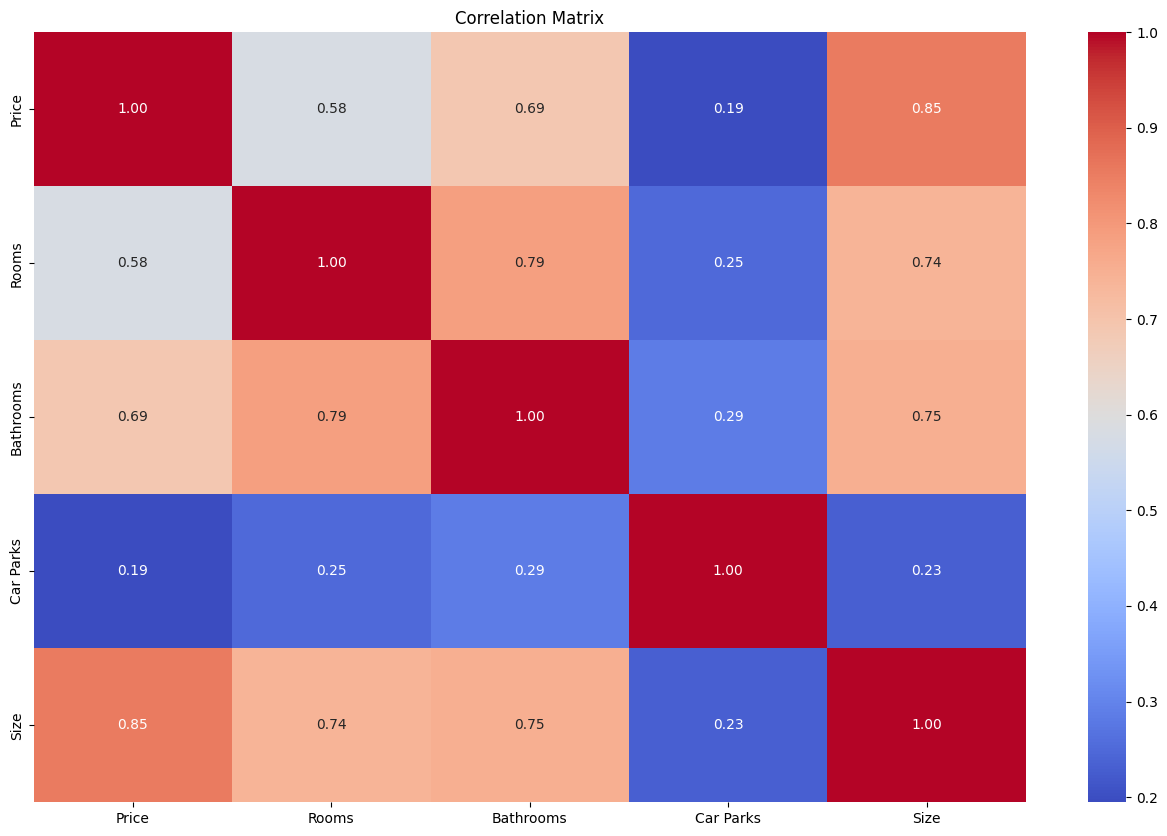

Price        1.000000
Size         0.852628
Bathrooms    0.691043
Rooms        0.580559
Car Parks    0.194652
Name: Price, dtype: float64


In [42]:
# Calculate the correlation matrix (for all locations)
corr_matrix = df[['Price', 'Rooms', 'Bathrooms', 'Car Parks', 'Size']].corr()


# Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


# Specifically, check the correlation of all features with 'Price'
price_corr = corr_matrix['Price'].sort_values(ascending=False)
print(price_corr)

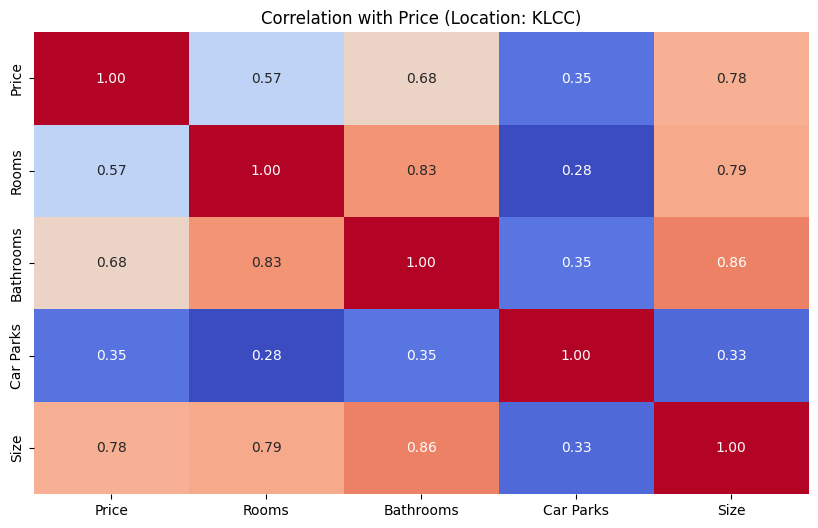

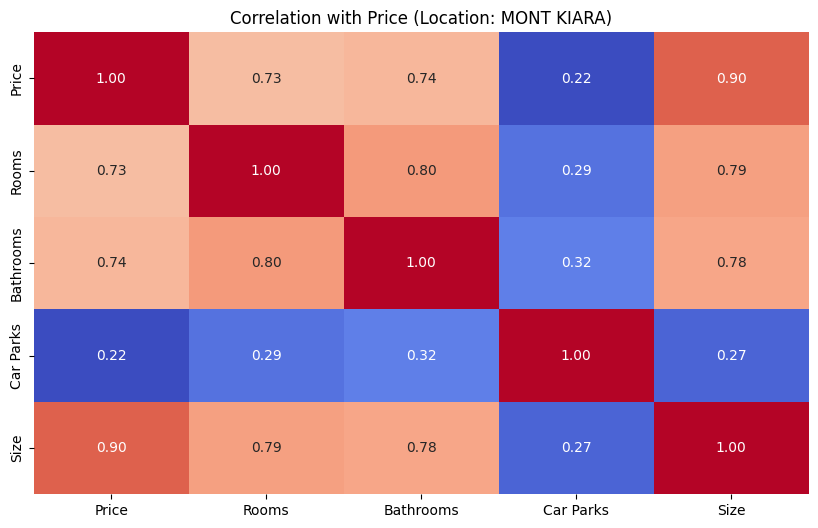

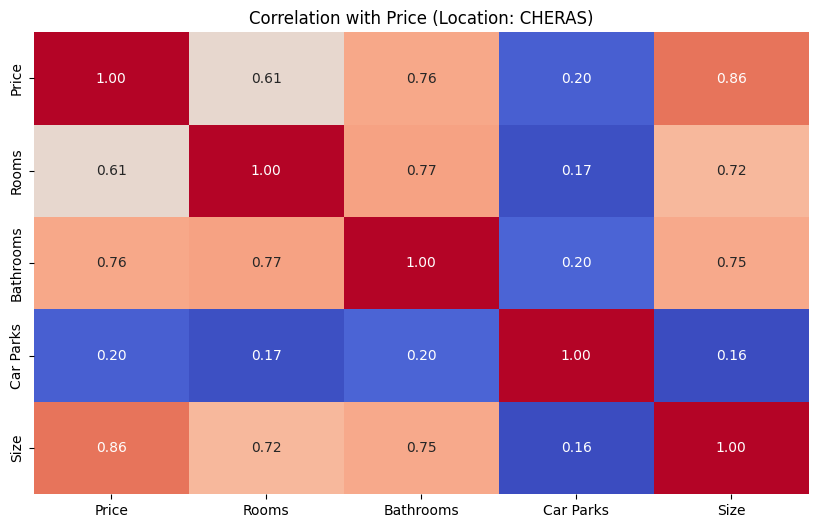

Correlation with Price (Location: KLCC):
               Price     Rooms  Bathrooms  Car Parks      Size
Price      1.000000  0.565293   0.684101   0.346925  0.776472
Rooms      0.565293  1.000000   0.830238   0.281449  0.789573
Bathrooms  0.684101  0.830238   1.000000   0.350178  0.860828
Car Parks  0.346925  0.281449   0.350178   1.000000  0.331362
Size       0.776472  0.789573   0.860828   0.331362  1.000000

Correlation with Price (Location: MONT KIARA):
               Price     Rooms  Bathrooms  Car Parks      Size
Price      1.000000  0.728240   0.742419   0.222040  0.900894
Rooms      0.728240  1.000000   0.804001   0.289537  0.792032
Bathrooms  0.742419  0.804001   1.000000   0.315841  0.780492
Car Parks  0.222040  0.289537   0.315841   1.000000  0.266066
Size       0.900894  0.792032   0.780492   0.266066  1.000000

Correlation with Price (Location: CHERAS):
               Price     Rooms  Bathrooms  Car Parks      Size
Price      1.000000  0.613041   0.759575   0.195613  0.859

In [43]:
# Filter the data for the specific locations
df_klcc = df[df['Location'] == 'KLCC']
df_kiara = df[df['Location'] == 'MONT KIARA']
df_cheras = df[df['Location'] == 'CHERAS']


# Calculate the correlation matrix for KLCC
corr_matrix_klcc = df_klcc[['Price', 'Rooms', 'Bathrooms', 'Car Parks', 'Size']].corr()


# Plot the heatmap for KLCC
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_klcc, annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
plt.title('Correlation with Price (Location: KLCC)')
plt.show()


# Calculate the correlation matrix for MONT KIARA
corr_matrix_kiara = df_kiara[['Price', 'Rooms', 'Bathrooms', 'Car Parks', 'Size']].corr()


# Plot the heatmap for MONT KIARA
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_kiara, annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
plt.title('Correlation with Price (Location: MONT KIARA)')
plt.show()


# Calculate the correlation matrix for CHERAS
corr_matrix_cheras = df_cheras[['Price', 'Rooms', 'Bathrooms', 'Car Parks', 'Size']].corr()


# Plot the heatmap for CHERAS
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_cheras, annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
plt.title('Correlation with Price (Location: CHERAS)')
plt.show()


# Print the correlations with Price for each location
print("Correlation with Price (Location: KLCC):\n", corr_matrix_klcc)
print("\nCorrelation with Price (Location: MONT KIARA):\n", corr_matrix_kiara)
print("\nCorrelation with Price (Location: CHERAS):\n", corr_matrix_cheras)

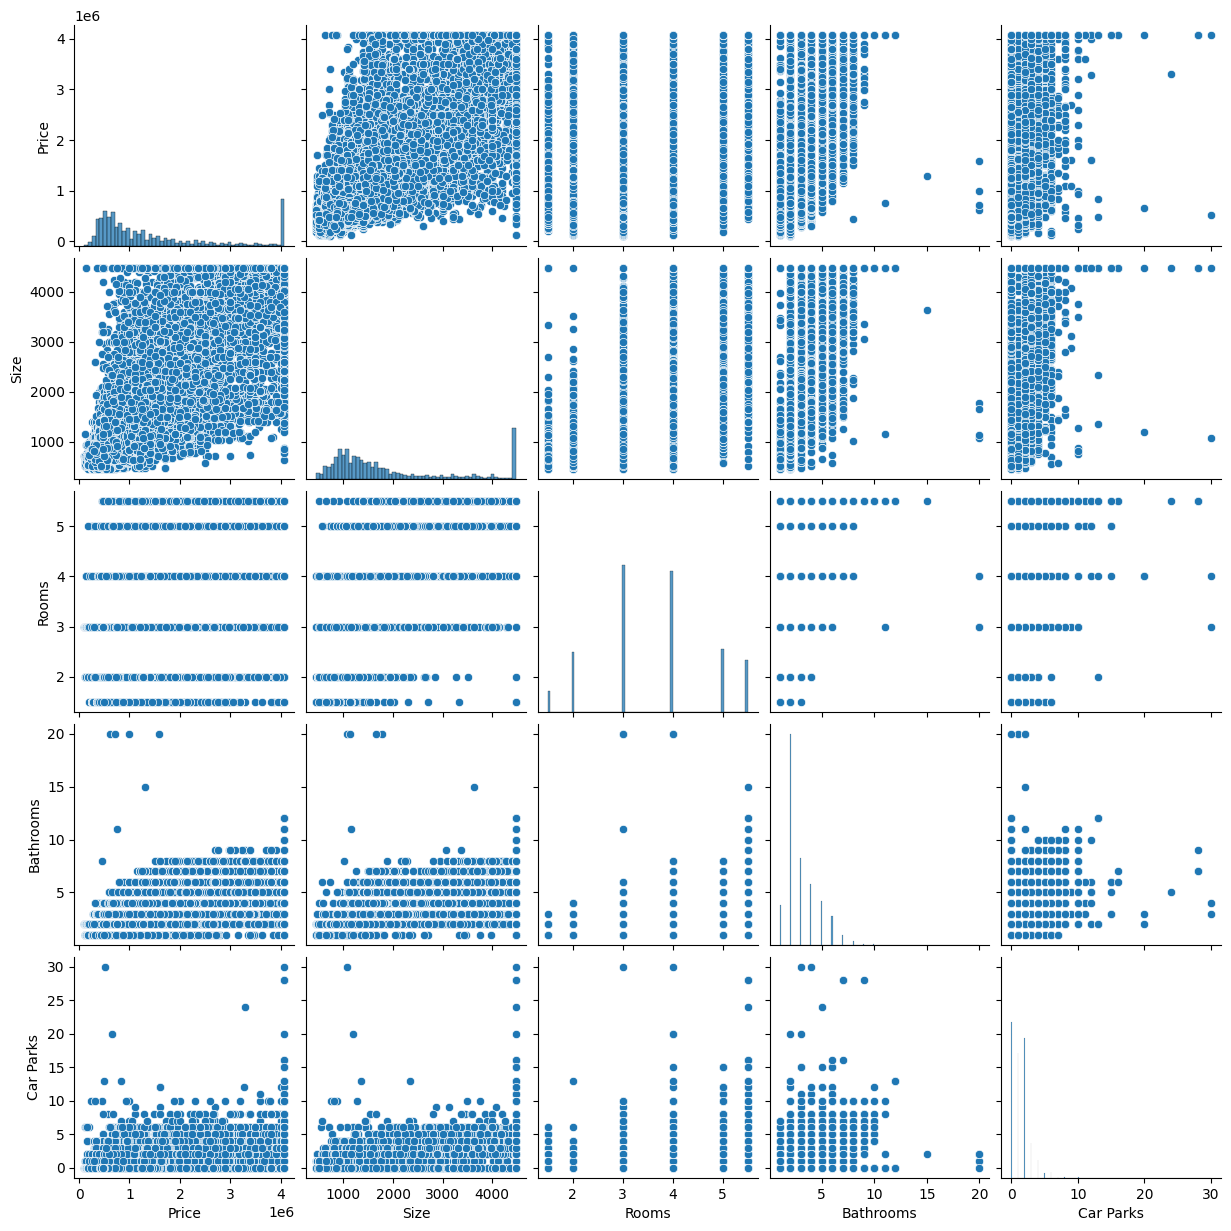

In [44]:
# Pair plot for selected features (for all locations)
sns.pairplot(df[['Price', 'Size', 'Rooms', 'Bathrooms', 'Car Parks']])
plt.show()

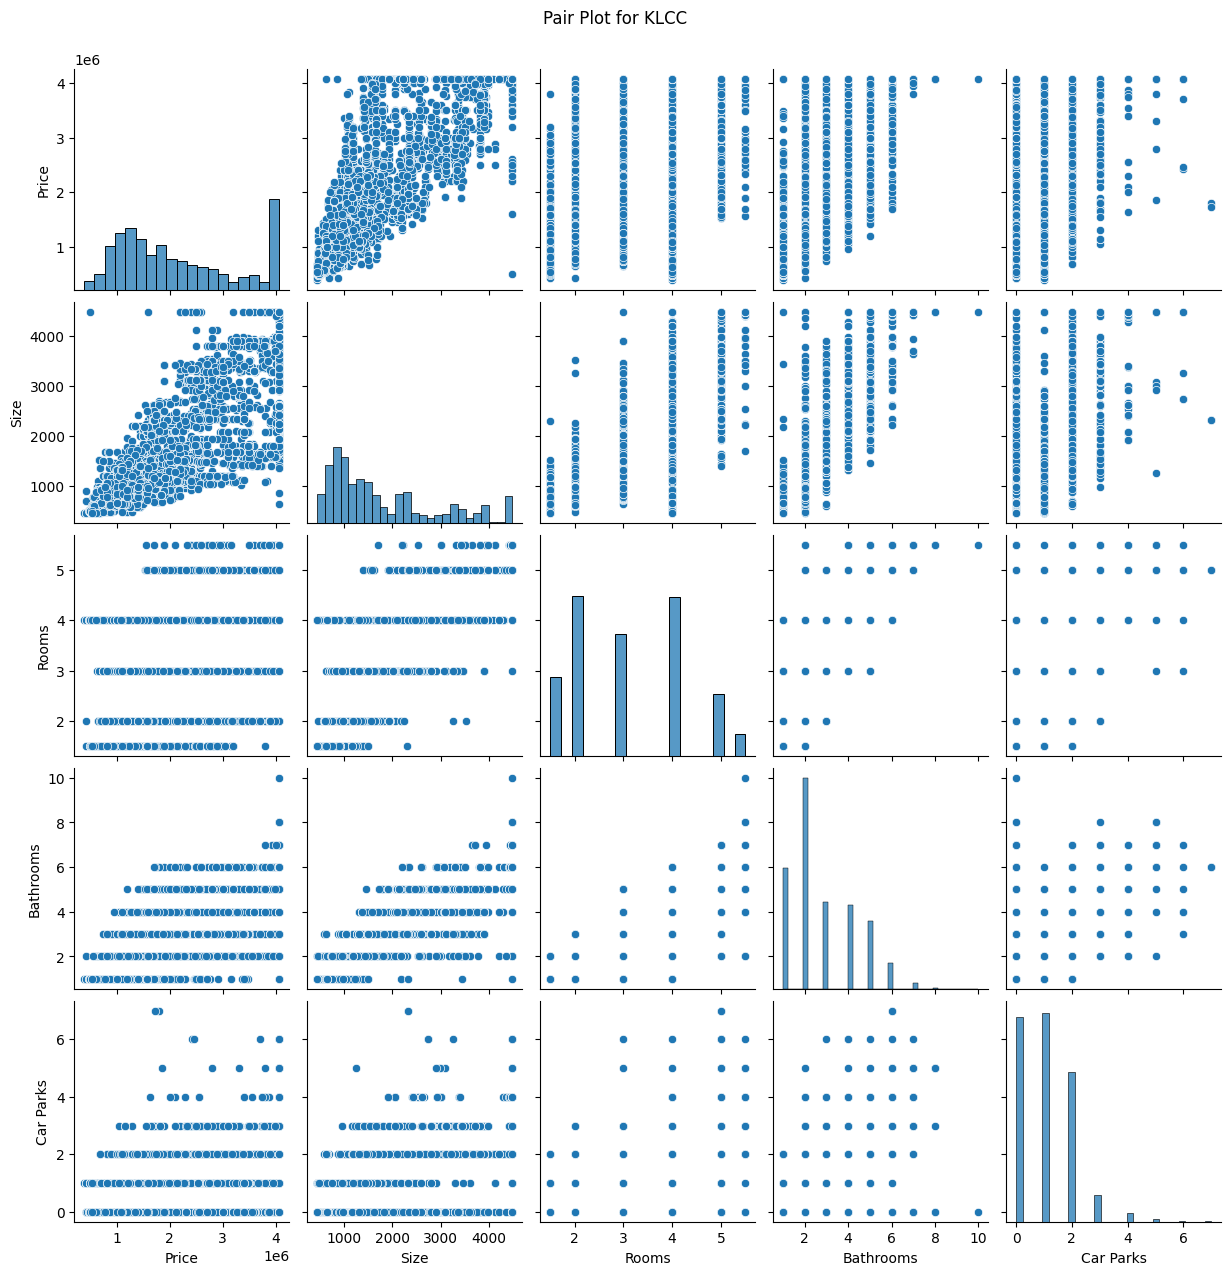

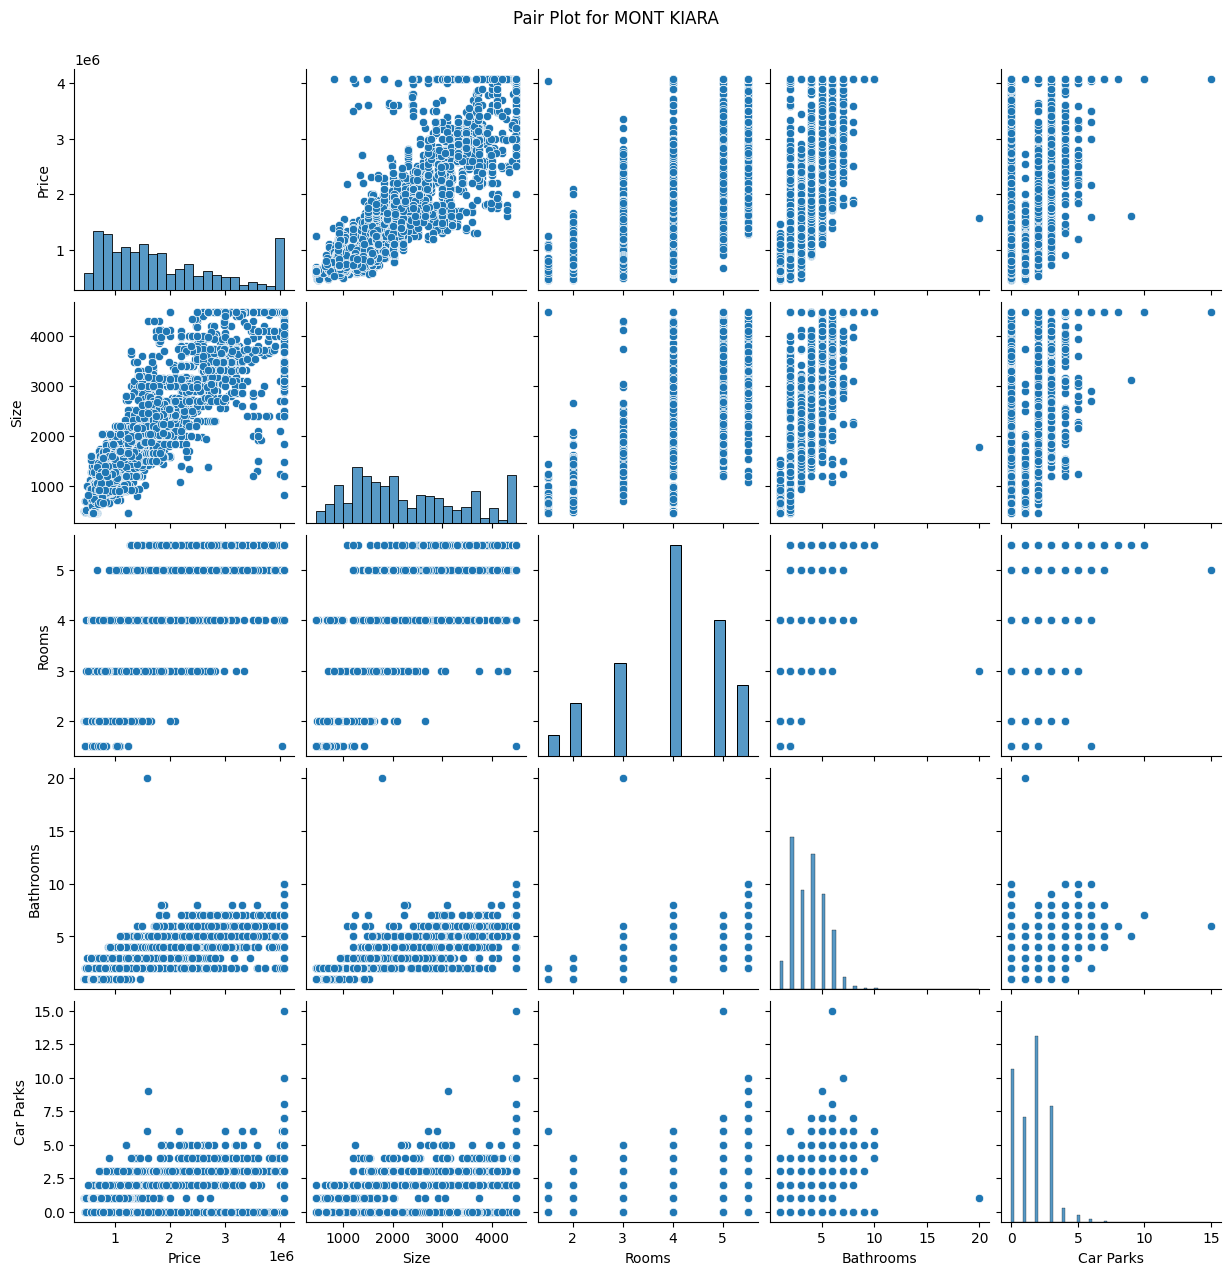

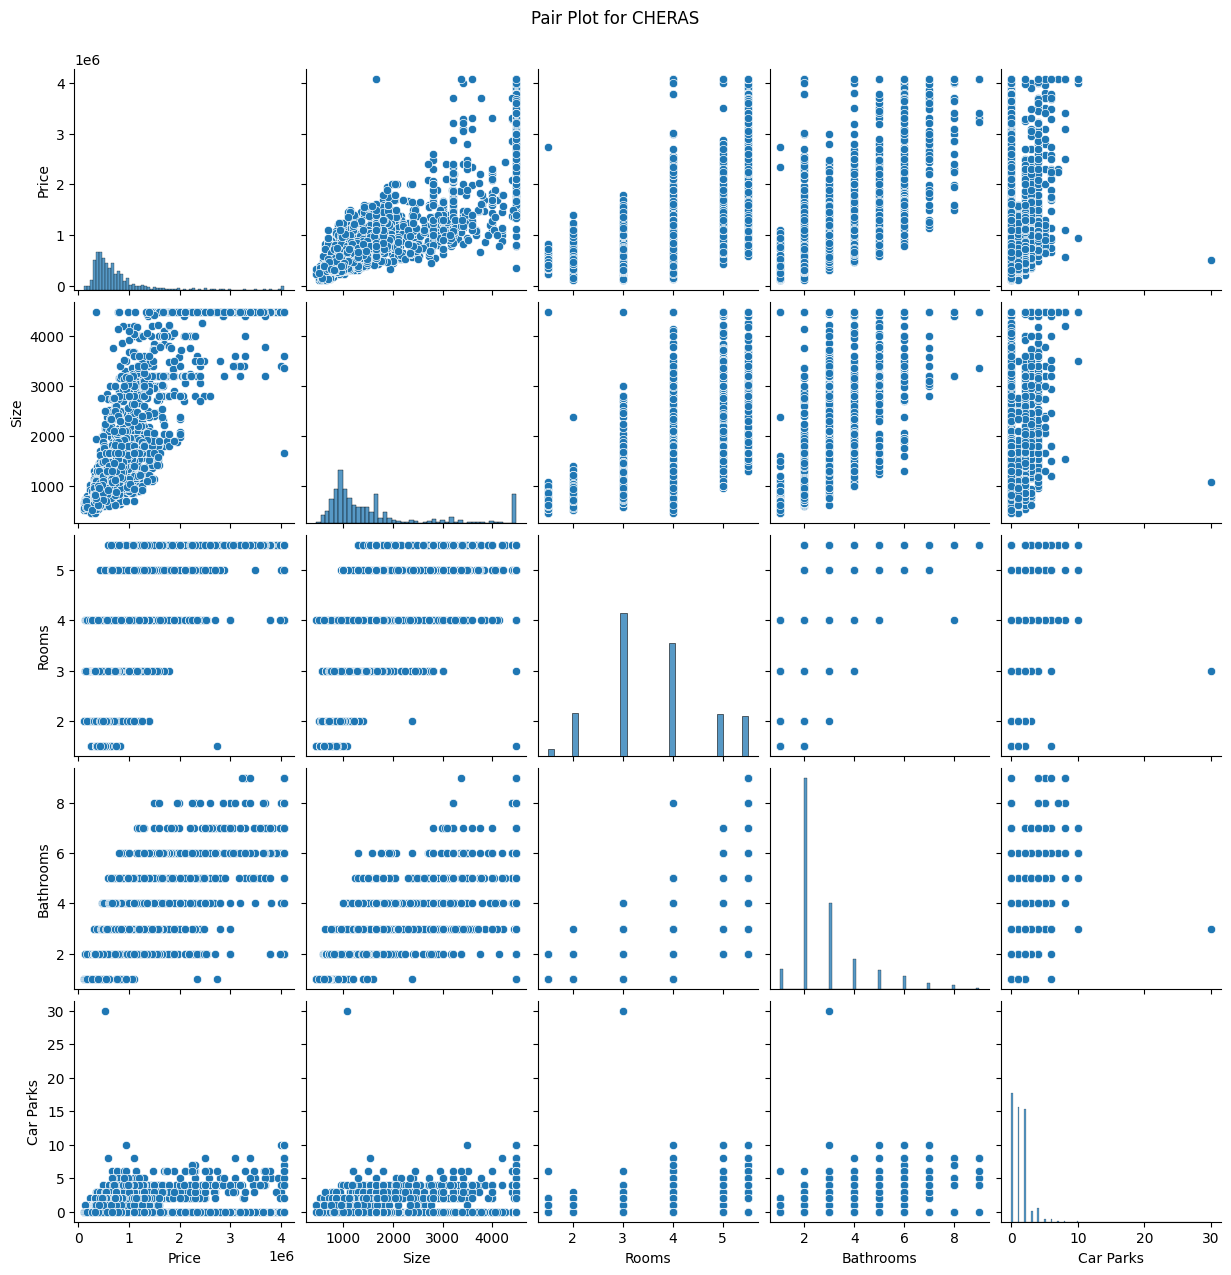

In [45]:
# Filter the data for the specific locations
locations = ['KLCC', 'MONT KIARA', 'CHERAS']


# Select features for pair plot
features = ['Price', 'Size', 'Rooms', 'Bathrooms', 'Car Parks']


for loc in locations:
    df_loc = df[df['Location'] == loc]
    sns.pairplot(df_loc, vars=features)
    plt.suptitle(f'Pair Plot for {loc}', y=1.02)
    plt.show()

In [46]:
from math import fabs 

train_test_score_diff = fabs(rf_model_train_score - rf_model_test_score)

# Print model performance metrics
print(f"Random Forest training score: {rf_model_train_score:.4f}")
print(f"Random Forest testing score: {rf_model_test_score:.4f}")
print(f"Difference between training and testing score: {train_test_score_diff:.4f}")
print(f"Random Forest Cross-Validation scores: {rf_cv_scores}")
print(f"Random Forest Cross-Validation Mean score: {np.mean(rf_cv_scores):.4f}")


Random Forest training score: 0.9832
Random Forest testing score: 0.9391
Difference between training and testing score: 0.0440
Random Forest Cross-Validation scores: [0.93928963 0.94050332 0.94113998 0.94333932 0.94150993]
Random Forest Cross-Validation Mean score: 0.9412


In [47]:
import scipy.stats as stats

top_location = df['Location'].value_counts()
top_location

Location
MONT KIARA                           5660
KLCC                                 5037
CHERAS                               4262
JALAN KLANG LAMA (OLD KLANG ROAD)    2734
SETAPAK                              2571
                                     ... 
HAPPY GARDEN                            1
LANDED SD                               1
OFF GASING INDAH,                       1
TAMAN MELATI                            1
SERI KEMBANGAN                          1
Name: count, Length: 102, dtype: int64

In [48]:
#Calculate t-test for means of 2 independent samples of scores
#Between prices and location

#Select prices of 2 top frequent locations
klcc_prices = df[df['Location'] == 'KLCC']['Price']
mont_prices = df[df['Location'] == 'MONT KIARA']['Price']

t_stat, p_value = stats.ttest_ind(klcc_prices, mont_prices)

#Print result of Test Statistic and P-value
print(f'Test Statistic: {t_stat}')
print(f'P-value: {p_value}')

print("\n")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis (H0).")
    print("There is sufficient evidence to suggest that there is a relationship between 2 Locations (KLCC and Mont Kiara) and Price.")
else:
    print("Fail to reject the null hypothesis (H0).")
    print("There is not sufficient evidence to suggest that there is a relationship between 2 Locations (KLCC and Mont Kiara) and Price.")

Test Statistic: 14.084978094197949
P-value: 1.1764475540247905e-44


Reject the null hypothesis (H0).
There is sufficient evidence to suggest that there is a relationship between 2 Locations (KLCC and Mont Kiara) and Price.


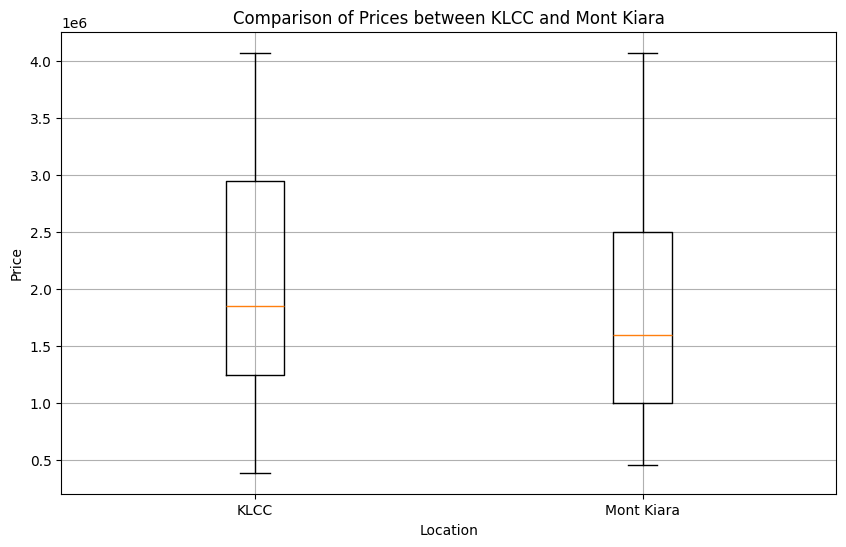

In [49]:
import matplotlib.pyplot as plt

# Create a box plot to compare prices between KLCC and Mont Kiara
plt.figure(figsize=(10, 6))
plt.boxplot([klcc_prices, mont_prices], labels=['KLCC', 'Mont Kiara'])
plt.title('Comparison of Prices between KLCC and Mont Kiara')
plt.xlabel('Location')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [50]:
df['Property Type'].value_counts()

Property Type
Condominium                   22426
Serviced Residence            12732
2-sty Terrace/Link House       4029
Bungalow                       3466
Semi-detached House            2091
3-sty Terrace/Link House       1629
Apartment                      1610
1-sty Terrace/Link House        791
2.5-sty Terrace/Link House      699
Residential Land                622
Townhouse                       531
Flat                            358
Name: count, dtype: int64

In [51]:
#Create contingency table (cross-tabulation)
contingency_table = pd.crosstab(df['Property Type'], pd.cut(df['Price'], bins=3))

#Perform chi square test
chi_square, p_value, dof, expected = stats.chi2_contingency(contingency_table)

#Print result of Chi-square Statistic and P-value
print(f"Chi-square statistic: {chi_square}")
print(f"P-value: {p_value}")

print("\n")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis (H0).")
    print("There is sufficient evidence to suggest that there is a relationship between Property Type and Price.")
else:
    print("Fail to reject the null hypothesis (H0).")
    print("There is not sufficient evidence to suggest that there is a relationship between Property Type and Price.")

Chi-square statistic: 21209.098450065776
P-value: 0.0


Reject the null hypothesis (H0).
There is sufficient evidence to suggest that there is a relationship between Property Type and Price.


([<matplotlib.axis.XTick at 0x1373429c0>,
 [Text(0.5, 0, 'Low'), Text(1.5, 0, 'Medium'), Text(2.5, 0, 'High')])

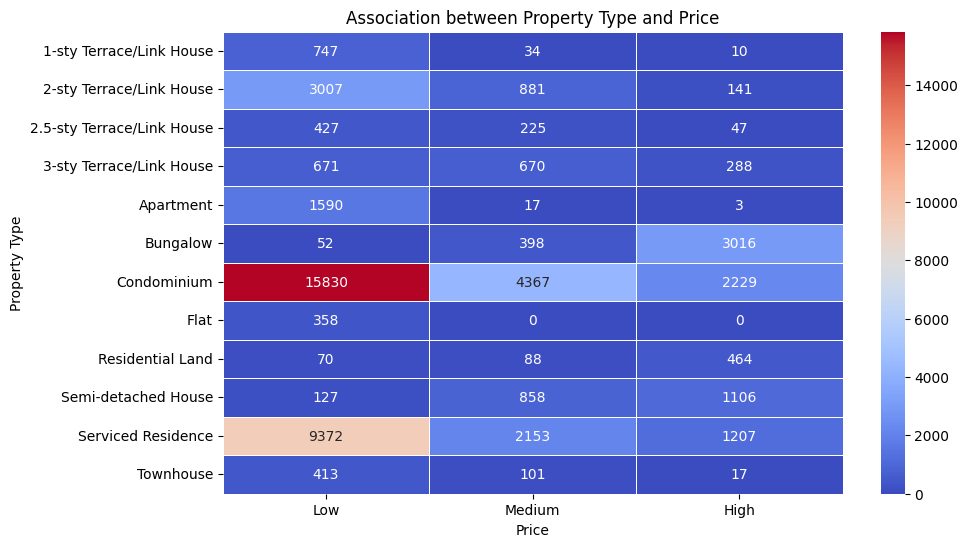

In [52]:
#Visualize using heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Association between Property Type and Price')
plt.xlabel('Price')
plt.ylabel('Property Type')
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['Low', 'Medium', 'High']) 

In [53]:
df['Furnishing'].value_counts()

Furnishing
Partly Furnished    25459
Fully Furnished     13208
Unfurnished         12317
Name: count, dtype: int64

In [54]:
#Group data by furnishing status
furnishing = [df[df['Furnishing'] == status]['Price'] for status in ['Partly Furnished', 'Fully Furnished', 'Unfurnished']]

#perform kruskal-wallis test
h_stat, p_value = stats.kruskal(*furnishing)

#Print result of kruskal-wallis h-statistic and P-value
print(f"Kruskal-Wallis H-statistic: {h_stat}")
print(f"P-value: {p_value}")

print("\n")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis.")
    print("There is sufficient evidence to suggest that there are differences in prices across different furnishing statuses.")
else:
    print("Fail to reject the null hypothesis.")
    print("There is not sufficient evidence to suggest that there are differences in prices across different furnishing statuses.")

Kruskal-Wallis H-statistic: 440.61032971862323
P-value: 2.1022413143322095e-96


Reject the null hypothesis.
There is sufficient evidence to suggest that there are differences in prices across different furnishing statuses.


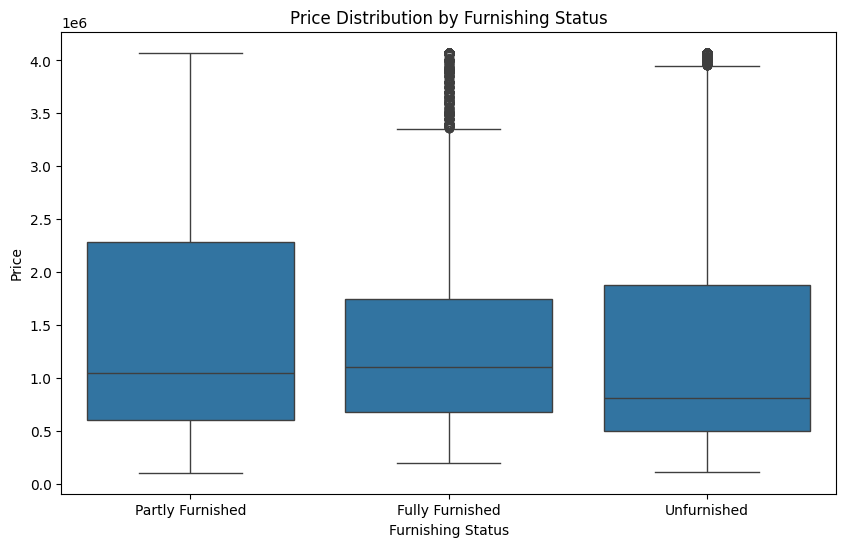

In [55]:
# Visualize using boxplots

plt.figure(figsize=(10, 6))
sns.boxplot(x='Furnishing', y='Price', data=df, order=['Partly Furnished', 'Fully Furnished', 'Unfurnished'])
plt.title('Price Distribution by Furnishing Status')
plt.xlabel('Furnishing Status')
plt.ylabel('Price')
plt.show()

In [56]:
df['Size'].value_counts()

Size
4477.5    5265
1650.0     956
1400.0     612
1100.0     579
950.0      511
          ... 
4316.0       1
3573.0       1
1437.0       1
3745.0       1
2881.0       1
Name: count, Length: 2538, dtype: int64

In [57]:
location_data = df[df['Location'] == 'KLCC']

unique_sizes = location_data['Size'].unique()

# Create groups based on size categories
groups = [location_data[location_data['Size'] == size]['Price'] for size in unique_sizes]

# Perform ANOVA test
f_stat, p_value = stats.f_oneway(*groups)

# Print results
print(f"ANOVA F-statistic: {f_stat}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis.")
    print("There is a significant difference in mean prices (KLCC) across size categories.")
else:
    print("Fail to reject the null hypothesis.")
    print("There is no significant difference in mean prices (KLCC) across size categories.")

ANOVA F-statistic: 56.70885836348738
P-value: 0.0
Reject the null hypothesis.
There is a significant difference in mean prices (KLCC) across size categories.


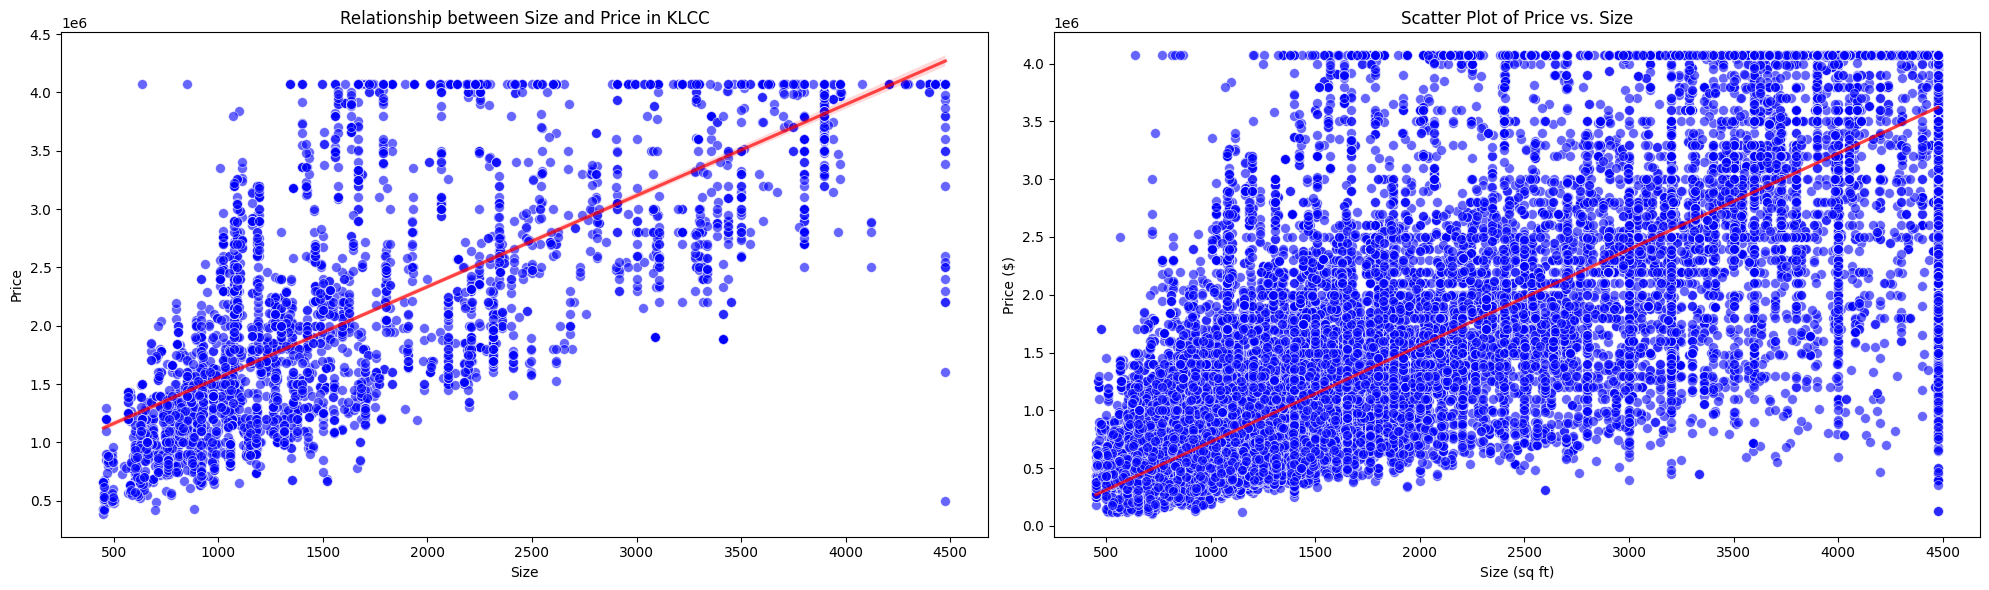

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Scatter plot on the first subplot
sns.scatterplot(x='Size', y='Price', data=location_data, color='blue', alpha=0.6, s=50, ax=axes[0])
sns.regplot(x='Size', y='Price', data=location_data, scatter=False, color='red', line_kws={"alpha":0.7}, ax=axes[0])
axes[0].set_title('Relationship between Size and Price in KLCC')
axes[0].set_xlabel('Size')
axes[0].set_ylabel('Price')

# Scatter plot on the second subplot
sns.scatterplot(x='Size', y='Price', data=df, color='blue', alpha=0.6, s=50, ax=axes[1])
sns.regplot(x='Size', y='Price', data=df, scatter=False, color='red', line_kws={"alpha":0.7}, ax=axes[1])
axes[1].set_title('Scatter Plot of Price vs. Size')
axes[1].set_xlabel('Size (sq ft)')
axes[1].set_ylabel('Price ($)')

# Show the plots
plt.tight_layout()
plt.show()

In [59]:
df['Bathrooms'].value_counts()

Bathrooms
2.0     22147
3.0      9163
4.0      6368
5.0      4574
1.0      4185
6.0      3056
7.0       988
8.0       354
9.0        92
10.0       35
11.0        9
12.0        8
20.0        4
15.0        1
Name: count, dtype: int64

In [60]:
#Group the data by bathrooms
bathrooms = [df[df['Bathrooms'] == bathrooms]['Price'] for bathrooms in df['Bathrooms'].unique()]

#perform ANOVA test
f_stat, p_value = stats.f_oneway(*bathrooms)

#Print result of anova statistic and P-value
print(f"ANOVA F-statistic: {f_stat}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis.")
    print("There is sufficient evidence to suggest that Price varies across different numbers of bathrooms.")
else:
    print("Fail to reject the null hypothesis.")
    print("There is not sufficient evidence to suggest that Price varies across different numbers of bathrooms.")

ANOVA F-statistic: 4035.655624407628
P-value: 0.0
Reject the null hypothesis.
There is sufficient evidence to suggest that Price varies across different numbers of bathrooms.


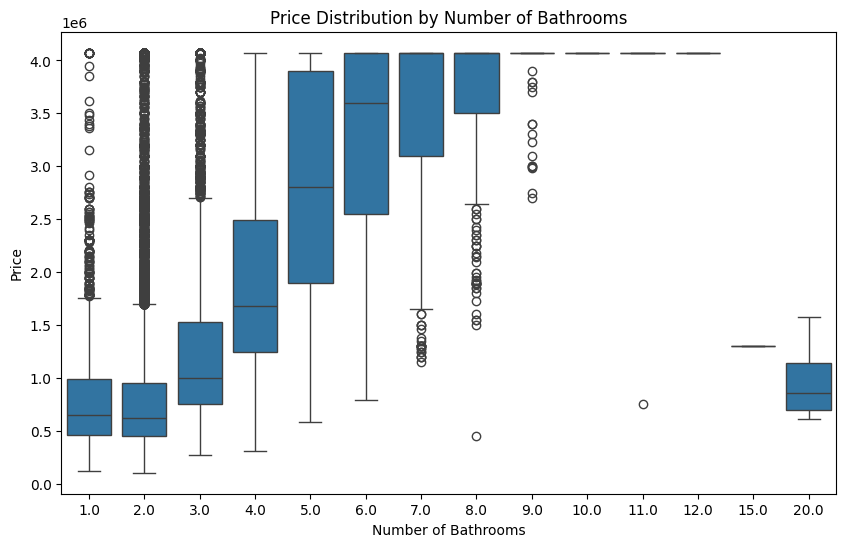

In [61]:
# Visualize the relationship with box plots
plt.figure(figsize=(10, 6))
sns.boxplot(x='Bathrooms', y='Price', data=df)
plt.title('Price Distribution by Number of Bathrooms')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price')
plt.show()

In [62]:
#Spearman rank correlation test
spearman_corr, p_value = stats.spearmanr(df['Car Parks'], df['Price'])

print(f"Spearman correlation coefficient: {spearman_corr}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis.")
    print("There is a significant association between Number of Car Parks and Price.")
else:
    print("Fail to reject the null hypothesis.")
    print("There is not a significant association between Number of Car Parks and Price.")

Spearman correlation coefficient: 0.09492088742670113
P-value: 2.355217652666625e-102
Reject the null hypothesis.
There is a significant association between Number of Car Parks and Price.


In [63]:
df[df['Price'] >= 4000000]

Location      Price  Rooms  Bathrooms  Car Parks  \
1              DAMANSARA HEIGHTS  4072500.0    5.5        7.0        0.0   
5            TAMAN TUN DR ISMAIL  4072500.0    5.5        5.0        4.0   
13           TAMAN TUN DR ISMAIL  4072500.0    5.5        5.0        5.0   
16     BUKIT TUNKU (KENNY HILLS)  4072500.0    5.5        7.0        4.0   
17             DAMANSARA HEIGHTS  4072500.0    5.5        7.0        0.0   
...                          ...        ...    ...        ...        ...   
53861                    SEPUTEH  4072500.0    4.0        2.0        0.0   
53877                 MONT KIARA  4072500.0    5.5        6.0        0.0   
53878                    BANGSAR  4072500.0    5.5        4.0        0.0   
53879                    BANGSAR  4072500.0    5.0        4.0        0.0   
53880                    BANGSAR  4072500.0    5.5        4.0        0.0   

          Property Type    Size        Furnishing  
1              Bungalow  4477.5  Partly Furnished  
5              Bungalow  4477.5  Partly Furnished  
13             Bungalow  4477.5  Partly Furnished  
16             Bungalow  4477.5  Partly Furnished  
17             Bungalow  4477.5  Partly Furnished  
...                 ...     ...               ...  
53861  Residential Land  4477.5       Unfurnished  
53877          Bungalow  4477.5  Partly Furnished  
53878          Bungalow  4477.5   Fully Furnished  
53879          Bungalow  4477.5       Unfurnished  
53880          Bungalow  4477.5  Partly Furnished  

[4962 rows x 8 columns]